In [66]:
import scipy

In [64]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import time

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

In [2]:
pip install rfpimp

Note: you may need to restart the kernel to use updated packages.


In [3]:
loans = pd.read_csv('accepted_2007_to_2018Q4.csv')

/Users/hui/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1345310, 24)

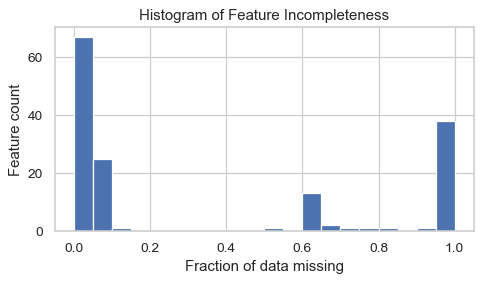

In [4]:
loans['loan_status'].value_counts(dropna=False)
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
loans.drop(labels=drop_list, axis=1, inplace=True)
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti'
             , 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low'
             , 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d'
             , 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose'
             , 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title','total_acc', 'verification_status','zip_code']
drop_list = [col for col in loans.columns if col not in keep_list]
loans.drop(labels=drop_list, axis=1, inplace=True)
loans['loan_status'].value_counts(normalize=True, dropna=False)
# do only once
loans.drop('id', axis=1, inplace=True)
loans.drop('grade', axis=1, inplace=True)
loans.drop(labels='title', axis=1, inplace=True)
loans.drop(labels='emp_title', axis=1, inplace=True)
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))
loans.drop('annual_inc', axis=1, inplace=True)
loans.drop(labels='zip_code', axis=1, inplace=True)
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
loans.drop('revol_bal', axis=1, inplace=True)
#do only once
loans['issue_d'] = pd.to_datetime(loans['issue_d'])
loans["issue_d"]=loans['issue_d'].dt.year
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))
# do only once
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)
loans.shape

In [5]:
def convert_class(dataset,outcome): # 给numbers分组
    y = dataset[outcome].values.tolist()
    for (i, item) in enumerate(y):
        if item in ("Fully Paid"):
            y[i] = 0
        if item in ("Charged Off"):
            y[i] = 1
    return y

def convert_column(dataset, num_column, cat_column):
    df_num = dataset[num_column]
 
    df_cat = dataset[cat_column].astype(str) #把category 换成数字
    encoder = LabelEncoder()
    df_cat = df_cat.apply(encoder.fit_transform)
    
    return pd.concat([df_cat,df_num],axis=1)

In [6]:
loans.head()

loan_amnt        term  int_rate  installment sub_grade  emp_length  \
0     3600.0   36 months     13.99       123.03        C4        10.0   
1    24700.0   36 months     11.99       820.28        C1        10.0   
2    20000.0   60 months     10.78       432.66        B4        10.0   
4    10400.0   60 months     22.45       289.91        F1         3.0   
5    11950.0   36 months     13.44       405.18        C3         4.0   

  home_ownership verification_status  issue_d loan_status             purpose  \
0       MORTGAGE        Not Verified     2015  Fully Paid  debt_consolidation   
1       MORTGAGE        Not Verified     2015  Fully Paid      small_business   
2       MORTGAGE        Not Verified     2015  Fully Paid    home_improvement   
4       MORTGAGE     Source Verified     2015  Fully Paid      major_purchase   
5           RENT     Source Verified     2015  Fully Paid  debt_consolidation   

  addr_state    dti  earliest_cr_line  open_acc  pub_rec  revol_util  \
0         PA   5.91              2003       7.0      0.0        29.7   
1         SD  16.06              1999      22.0      0.0        19.2   
2         IL  10.78              2000       6.0      0.0        56.2   
4         PA  25.37              1998      12.0      0.0        64.5   
5         GA  10.20              1987       5.0      0.0        68.4   

   total_acc initial_list_status application_type  mort_acc  \
0       13.0                   w       Individual       1.0   
1       38.0                   w       Individual       4.0   
2       18.0                   w        Joint App       5.0   
4       35.0                   w       Individual       6.0   
5        6.0                   w       Individual       0.0   

   pub_rec_bankruptcies  log_annual_inc  fico_score  
0                   0.0        4.740371       677.0  
1                   0.0        4.812920       717.0  
2                   0.0        4.799347       697.0  
4                   0.0        5.018842       697.0  
5                   0.0        4.531492       692.0

In [7]:
cat_col= ["term","sub_grade","home_ownership","verification_status",
          "purpose","addr_state","initial_list_status","application_type"]

num_col = ["loan_amnt","int_rate","installment","issue_d","dti","earliest_cr_line","emp_length",
           "open_acc","pub_rec","revol_util","total_acc","mort_acc","pub_rec_bankruptcies","fico_score","loan_status"]
loans = convert_column(loans,num_col,cat_col)
loans["y"] = pd.factorize(loans["loan_status"])[0]
loans.drop('loan_status', axis=1, inplace=True)
loans["emp_length"].fillna(0,inplace = True)
loans["dti"].fillna(loans["dti"].mean(),inplace = True)
loans["mort_acc"].fillna(loans["mort_acc"].mean(),inplace = True)
loans["pub_rec_bankruptcies"].fillna(loans["pub_rec_bankruptcies"].mean(),inplace = True)
loans["revol_util"].fillna(loans["revol_util"].mean(),inplace = True)

In [8]:
copy = loans.copy()

In [37]:
loans = copy

In [11]:
loans = loans.drop(["application_type","pub_rec_bankruptcies","addr_state","total_acc","pub_rec",
              "purpose","emp_length","initial_list_status"],axis =1)
loans.shape

(1345310, 15)

In [38]:
data = loans[loans["dti"] <= 100]

In [39]:
#data = data.sample(50000)
data.shape

(1344777, 23)

In [14]:
def print_score(forest):
    y_predicted = forest.predict_proba(X_test)[:, 1]
    res = [forest.score(X_train, y_train), forest.score(X_test, y_test),metrics.roc_auc_score(y_test, y_predicted)]
    if hasattr(forest, 'oob_score_'): res.append(forest.oob_score_)
    print(res)
    return res

In [15]:
def r2(forest, X_train, y_train):
    return r2_score(y_train, forest.predict(X_train))

In [16]:
def Plot_predictor_importance(forest, data):
    feature_columns = data.columns
    feature_importances = forest.feature_importances_
    sorted_idx = np.argsort(-feature_importances)
    y_pos  = np.arange(sorted_idx.shape[0])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    ax1.barh(y_pos, 
            feature_importances[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
    ax1.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
    ax1.set_title('Gini Importance',fontsize = 15)
    
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)
    
    ax2.barh(np.arange(len(perm_imp_rfpimp.values)),np.ravel(perm_imp_rfpimp.values), align='center',color='green', 
            ecolor='black', height= 0.7)
    ax2.set_yticks(np.arange(len(perm_imp_rfpimp.values)))
    ax2.set_yticklabels(perm_imp_rfpimp.index.values,fontsize = 10)
    ax2.invert_yaxis()
    #ax2.set_xlabel('Relative Importance',fontsize = 15)
    ax2.set_title('Permutation importance',fontsize = 15)
    plt.show()
    plt.tight_layout();
    fig.savefig("imp2.png", bbox_inches='tight')
    return feature_importances, perm_imp_rfpimp

In [17]:
def two_imp(data,forest,perm_imp_rfpimp):
    fig, ax = plt.subplots(1,1,figsize =(10,6))
    feature_importances = forest.feature_importances_
    perm_imp_rfpimp["gini"] = np.nan
    for i in np.arange(len(feature_importances)):
        for e in np.arange(len(feature_importances)):
            if perm_imp_rfpimp.index.values[i] == data.columns[e]:
                 perm_imp_rfpimp["gini"][i] = feature_importances[e]
    x = np.ravel(perm_imp_rfpimp['Importance']).tolist()
    y = np.ravel(perm_imp_rfpimp['gini']).tolist()
    ax.scatter(x,y)
    ax.set_xlabel('Permutaion Importance',fontsize = 15)
    ax.set_ylabel('Gini Impurity',fontsize = 15)
    label = np.ravel(perm_imp_rfpimp.index.values)
    fig.savefig("scatter.png", bbox_inches='tight')
    for x, y, label in zip(x, y, label):
        ax.annotate(label, xy=(x, y), xytext=(-60, 20), ha='left',
                textcoords='offset points',arrowprops=dict(arrowstyle="->",color="red"))


In [100]:
from scipy.cluster import hierarchy as hc
def link_plot(data):
    corr = np.round(scipy.stats.spearmanr(data).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(8,5))
    dendrogram = hc.dendrogram(z, labels=data.columns,
        orientation='left', leaf_font_size=13)
    fig.savefig("22link.png",bbox_inches='tight')
    plt.show()


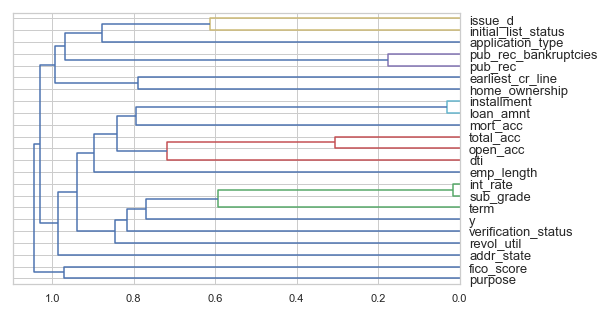

In [101]:
link_plot(data)

In [98]:
data.shape

(1344777, 23)

In [557]:
#tuning
ccc=[]
bbb =[]
for i in [5,10,20,30,40,50,60,80,100,125,150,175,200]:
    print(i)
    cc=[]
    oob =[]
    for e in np.arange(10):
        df = data.sample(50000)
        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
        forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=i, max_features=0.5, n_jobs=-1, oob_score=True)
        forest.fit(X_train, y_train)
        cc.append(print_score(forest)[2])
        oob.append(print_score(forest)[3])
    ccc.append(cc)
    bbb.append(oob)
        

5
10
20
30
40
50
60
80
100
125
150
175
200


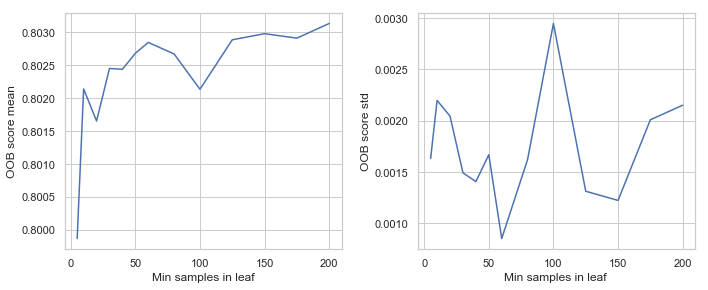

In [559]:
fig,(ax1, ax2)= plt.subplots(nrows =1, ncols =2, figsize=(10,4))
leaf= [5,10,20,30,40,50,60,80,100,125,150,175,200]
mean =  [np.mean(i) for i in bbb]
std = [np.std(i) for i in bbb]

ax1.plot(leaf,mean,"-")
ax2.plot(leaf,std,"-")
#ax.plot(trees,ccc,"-")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax1.set_ylabel('OOB score mean');ax2.set_ylabel('OOB score std');
plt.tight_layout();ax2.set_xlabel("Min samples in leaf ");ax1.set_xlabel("Min samples in leaf")
fig.savefig('tune leaf.png', bbox_inches='tight')

In [542]:
#tuning
ccc_tree=[]
bbb_tree =[]
trees = [10,20,30,40,50,60,80,100,120,130,150,160,175,200]
for i in trees:
    print(i)
    cc=[]
    oob =[]
    for e in np.arange(10):
        df = data.sample(50000)
        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
        forest = RandomForestClassifier(n_estimators=i, min_samples_leaf=50, max_features=0.5, n_jobs=-1, oob_score=True)
        forest.fit(X_train, y_train)
        cc.append(print_score(forest)[2])
        oob.append(print_score(forest)[3])
    ccc_tree.append(cc)
    bbb_tree.append(oob)
        

10
20
30
40
50
60
80
100
120
130
150
160
175
200


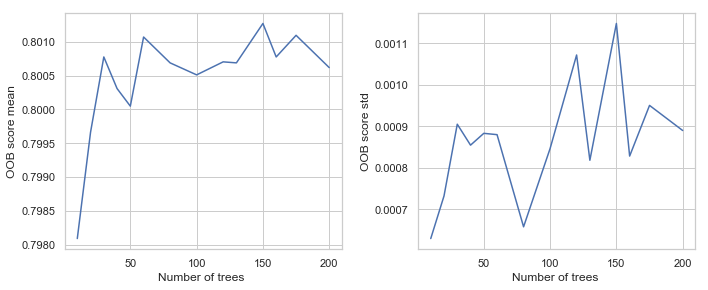

In [553]:
fig,(ax1, ax2)= plt.subplots(nrows =1, ncols =2, figsize=(10,4))

mean =  [np.mean(i) for i in bbb_tree]
std = [np.std(i) for i in bbb_tree]

ax1.plot(trees,mean,"-")
ax2.plot(trees,std,"-")
#ax.plot(trees,ccc,"-")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax1.set_ylabel('OOB score mean');ax2.set_ylabel('OOB score std');
plt.tight_layout();ax2.set_xlabel("Number of trees ");ax1.set_xlabel("Number of trees ")
fig.savefig('tune tree.png', bbox_inches='tight')

In [678]:
#tuning
ccc_fea=[]
bbb_fea =[]
features = [2,3,4,5,6,7,8,9,10]
for i in features:
    print(i)
    cc=[]
    oob =[]
    for e in np.arange(20):
        df = data.sample(50000)
        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
        forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=60, max_features=i, n_jobs=-1, oob_score=True)
        forest.fit(X_train, y_train)
        cc.append(print_score(forest)[2])
        oob.append(print_score(forest)[3])
    ccc_fea.append(cc)
    bbb_fea.append(oob)
        

2
[0.802175, 0.8045, 0.7093609788105536, 0.8011]
[0.802175, 0.8045, 0.7093609788105536, 0.8011]
[0.799375, 0.8046, 0.7073168484851258, 0.798675]
[0.799375, 0.8046, 0.7073168484851258, 0.798675]
[0.8023, 0.8041, 0.7167397931305054, 0.80135]
[0.8023, 0.8041, 0.7167397931305054, 0.80135]
[0.802175, 0.8062, 0.7123208864250061, 0.800725]
[0.802175, 0.8062, 0.7123208864250061, 0.800725]
[0.80225, 0.7996, 0.7029976500536093, 0.80165]
[0.80225, 0.7996, 0.7029976500536093, 0.80165]
[0.802425, 0.8101, 0.7094548949541224, 0.80085]
[0.802425, 0.8101, 0.7094548949541224, 0.80085]
[0.8025, 0.7977, 0.7134668801107602, 0.80185]
[0.8025, 0.7977, 0.7134668801107602, 0.80185]
[0.800625, 0.8006, 0.72429625, 0.7997]
[0.800625, 0.8006, 0.72429625, 0.7997]
[0.799525, 0.8023, 0.721111548700313, 0.798875]
[0.799525, 0.8023, 0.721111548700313, 0.798875]
[0.802775, 0.7973, 0.7233912063808932, 0.8025]
[0.802775, 0.7973, 0.7233912063808932, 0.8025]
[0.7978, 0.8025, 0.7144241927750965, 0.7966]
[0.7978, 0.8025, 0.71

[0.80815, 0.8006, 0.7043757879369332, 0.804025]
[0.80565, 0.8073, 0.7234097563258775, 0.801375]
[0.80565, 0.8073, 0.7234097563258775, 0.801375]
[0.805775, 0.8084, 0.7040043772053646, 0.80085]
[0.805775, 0.8084, 0.7040043772053646, 0.80085]
[0.80785, 0.8047, 0.7085613424181476, 0.8026]
[0.80785, 0.8047, 0.7085613424181476, 0.8026]
[0.8065, 0.8053, 0.7217476729938573, 0.802225]
[0.8065, 0.8053, 0.7217476729938573, 0.802225]
[0.810875, 0.8074, 0.7050012620362399, 0.805225]
[0.810875, 0.8074, 0.7050012620362399, 0.805225]
[0.805775, 0.7981, 0.7058256223935111, 0.801675]
[0.805775, 0.7981, 0.7058256223935111, 0.801675]
[0.8085, 0.8001, 0.7157514446229316, 0.803875]
[0.8085, 0.8001, 0.7157514446229316, 0.803875]
[0.809075, 0.8016, 0.7045794077412022, 0.803175]
[0.809075, 0.8016, 0.7045794077412022, 0.803175]
[0.807825, 0.8005, 0.7194014739819847, 0.8027]
[0.807825, 0.8005, 0.7194014739819847, 0.8027]
[0.8086, 0.8094, 0.7104526154819908, 0.804]
[0.8086, 0.8094, 0.7104526154819908, 0.804]
[0.8

[0.8125, 0.7973, 0.7159149338045827, 0.80555]
[0.809325, 0.8031, 0.712250489509437, 0.801375]
[0.809325, 0.8031, 0.712250489509437, 0.801375]
[0.810875, 0.8056, 0.7118986404115878, 0.8049]
[0.810875, 0.8056, 0.7118986404115878, 0.8049]
[0.808525, 0.7993, 0.7151908334976569, 0.8031]
[0.808525, 0.7993, 0.7151908334976569, 0.8031]
[0.809225, 0.8058, 0.7022934210512117, 0.803375]
[0.809225, 0.8058, 0.7022934210512117, 0.803375]
[0.810725, 0.8043, 0.7195791767773771, 0.804125]
[0.810725, 0.8043, 0.7195791767773771, 0.804125]


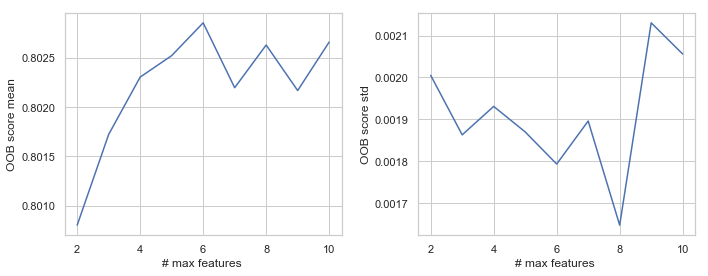

In [680]:
fig,(ax1, ax2)= plt.subplots(nrows =1, ncols =2, figsize=(10,4))

features = [2,3,4,5,6,7,8,9,10]

mean =  [np.mean(i) for i in bbb_fea]
std = [np.std(i) for i in bbb_fea]

ax1.plot(features,mean,"-")
ax2.plot(features,std,"-")
#ax.plot(trees,ccc,"-")

ax.xaxis.label.set_fontsize(10)
#for label in (ax.get_xticklabels() + ax.get_yticklabels()):
   # label.set_fontsize(9)
ax1.set_xlabel("# max features ");ax1.set_ylabel('OOB score mean');ax2.set_ylabel('OOB score std');
plt.tight_layout();ax2.set_xlabel("# max features ")
fig.savefig('tunefea.png', bbox_inches='tight')

In [627]:
def Plot_predictor_importance(forest, data):  #original
    feature_columns = data.columns
    feature_importances = forest.feature_importances_
    sorted_idx = np.argsort(-feature_importances)
    y_pos  = np.arange(sorted_idx.shape[0])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    ax1.barh(y_pos, 
            feature_importances[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
    ax1.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
    ax1.set_title('Gini Importance',fontsize = 15)
    
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)
    
    ax2.barh(np.arange(len(perm_imp_rfpimp.values)),np.ravel(perm_imp_rfpimp.values), align='center',color='green', 
            ecolor='black', height= 0.7)
    ax2.set_yticks(np.arange(len(perm_imp_rfpimp.values)))
    ax2.set_yticklabels(perm_imp_rfpimp.index.values,fontsize = 10)
    ax2.invert_yaxis()
    #ax2.set_xlabel('Relative Importance',fontsize = 15)
    ax2.set_title('Permutation importance',fontsize = 15)
    plt.show()
    plt.tight_layout();
    fig.savefig("imp2.png", bbox_inches='tight')
    return feature_importances, perm_imp_rfpimp

In [735]:
df = data.sample(50000)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=15, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
print_score(forest)
    
feature_importances = forest.feature_importances_
perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)    
perm_imp_rfpimp

[0.8079, 0.8061, 0.7107204525539921, 0.8013]


Importance
Feature                         
dti                     0.040497
sub_grade               0.039270
int_rate                0.033134
term                    0.031907
loan_amnt               0.014726
installment             0.014726
issue_d                 0.012272
fico_score              0.008590
revol_util              0.007363
addr_state              0.002454
earliest_cr_line        0.002454
mort_acc                0.002454
verification_status     0.001227
pub_rec                 0.001227
total_acc               0.001227
application_type        0.000000
purpose                 0.000000
emp_length              0.000000
pub_rec_bankruptcies    0.000000
initial_list_status    -0.001227
home_ownership         -0.002454
open_acc               -0.006136

In [ ]:
def two_imp(data,forest,perm_imp_rfpimp):
    fig, ax = plt.subplots(1,1,figsize =(10,6))
    feature_importances = forest.feature_importances_
    perm_imp_rfpimp["gini"] = np.nan
    for i in np.arange(len(feature_importances)):
        for e in np.arange(len(feature_importances)):
            if perm_imp_rfpimp.index.values[i] == data.columns[e]:
                 perm_imp_rfpimp["gini"][i] = feature_importances[e]
    x = np.ravel(perm_imp_rfpimp['Importance']).tolist()
    y = np.ravel(perm_imp_rfpimp['gini']).tolist()
    ax.scatter(x,y)
    ax.set_xlabel('Permutaion Importance',fontsize = 15)
    ax.set_ylabel('Gini Impurity',fontsize = 15)
    label = np.ravel(perm_imp_rfpimp.index.values)
    fig.savefig("scatter.png", bbox_inches='tight')
    for x, y, label in zip(x, y, label):
        ax.annotate(label, xy=(x, y), xytext=(-60, 20), ha='left',
                textcoords='offset points',arrowprops=dict(arrowstyle="->",color="red"))


In [765]:
imp_df = pd.DataFrame(data.columns[:-1])
imp_df["per"]= np.nan
for i in np.arange(len(data.columns[:-1])):
    for j in np.arange(len(perm_imp_rfpimp.index)):
        if data.columns[i] == perm_imp_rfpimp.index[j] :
            imp_df["per"][i] = perm_imp_rfpimp.values[j]
list_per = imp_df["per"].values.tolist()

In [126]:
data = loans[loans["dti"] <= 100]
data.shape

(1344777, 23)

(50000, 21)

In [127]:
imp_all =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]] # try to take the average importance
per_all =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
auc =[]
for i in np.arange(30):
    df = data.sample(50000)
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=6, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    auc.append(print_score(forest)[2])
    
    feature_importances = forest.feature_importances_
    for e in np.arange(len(feature_importances)):
        imp_all[e].append(feature_importances[e])
        
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2) 
    
    imp_df = pd.DataFrame(data.columns[:-1])
    imp_df["per"]= np.nan
    for i in np.arange(len(data.columns[:-1])):
        for j in np.arange(len(perm_imp_rfpimp.index)):
            if data.columns[i] == perm_imp_rfpimp.index[j] :
                imp_df["per"][i] = perm_imp_rfpimp.values[j]
    list_per = imp_df["per"].values.tolist()
    
    for j in np.arange(len(list_per)):
        per_all[j].append(list_per[j])
        
newper = [np.mean(i) for i in per_all]
newimp = [np.mean(i) for i in imp_all]


0
[0.80555, 0.8078, 0.700898286001206, 0.8004]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
[0.80725, 0.8038, 0.7106520625, 0.801625]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
[0.808775, 0.8008, 0.7104179260811292, 0.80355]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
[0.80645, 0.8068, 0.7202581189509353, 0.800775]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4
[0.808625, 0.7974, 0.7163341411542397, 0.804725]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5
[0.80835, 0.8079, 0.7029936209034267, 0.802675]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6
[0.80295, 0.8003, 0.7146701623388733, 0.798475]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
[0.807375, 0.8016, 0.7101427615625604, 0.80185]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8
[0.807425, 0.7965, 0.7126772929493118, 0.801175]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9
[0.8057, 0.8038, 0.7194884056706345, 0.80035]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10
[0.809425, 0.8083, 0.7137115649088832, 0.80325]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11
[0.80835, 0.8083, 0.7130787963347357, 0.802775]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


12
[0.8087, 0.8063, 0.7134533275727032, 0.80335]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13
[0.80665, 0.8043, 0.7139101627795583, 0.801325]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


14
[0.805325, 0.8027, 0.7223681661378116, 0.800925]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


15
[0.808375, 0.7981, 0.7239579627565379, 0.8029]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


16
[0.810875, 0.8049, 0.7199225665395015, 0.805975]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


17
[0.80525, 0.8029, 0.7151295434124131, 0.8006]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18
[0.809075, 0.801, 0.7104754734973243, 0.80455]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


19
[0.80585, 0.8083, 0.7106573488796366, 0.800475]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


20
[0.806325, 0.8015, 0.7084947295423628, 0.8012]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


21
[0.81115, 0.8039, 0.7209977801680322, 0.805925]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


22
[0.806775, 0.8025, 0.7056604572855248, 0.80195]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


23
[0.80775, 0.7997, 0.7080649902369633, 0.8029]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24
[0.808625, 0.8044, 0.7044742739773456, 0.804275]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


25
[0.8051, 0.8025, 0.7120129436523409, 0.799825]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


26
[0.80735, 0.8023, 0.7135645803794688, 0.8029]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


27
[0.808875, 0.8012, 0.7140190814646898, 0.80435]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


28
[0.809225, 0.7988, 0.7209407188022052, 0.8036]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29
[0.809525, 0.8023, 0.7074954146816493, 0.804375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


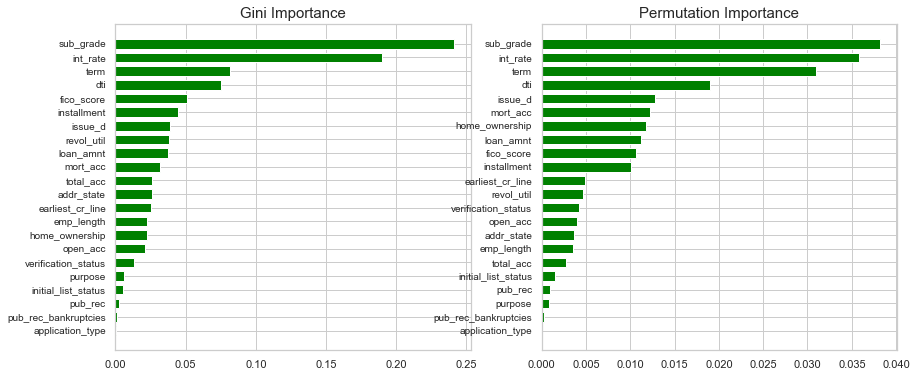

In [128]:
feature_columns = data.columns
sorted_idx = np.argsort(-np.array(newimp))
y_pos  = np.arange(sorted_idx.shape[0])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.barh(y_pos, 
            np.array(newimp)[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
ax1.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax1.set_title('Gini Importance',fontsize = 15)

sorted_idxp = np.argsort(-np.array(newper))
y_posp  = np.arange(sorted_idxp.shape[0])
ax2.barh(y_pos, 
            np.array(newper)[sorted_idxp], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax2.set_yticks(y_posp)
ax2.set_yticklabels(feature_columns[sorted_idxp],fontsize = 10)
ax2.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax2.set_title('Permutation Importance',fontsize = 15)
fig.savefig("22imp.png", bbox_inches='tight')


In [26]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [27]:
from adjustText import adjust_text

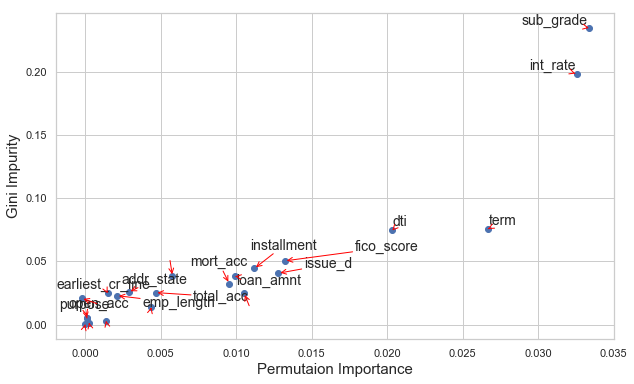

In [95]:
fig, ax = plt.subplots(figsize =(10,6))
x = newper; y = newimp
ax.set_xlabel('Permutaion Importance',fontsize = 15)
ax.set_ylabel('Gini Impurity',fontsize = 15)

plt.plot(x, y, 'bo');
label = ['term', 'sub_grade', '  ', ' ', 'purpose',
       'addr_state', ' ', ' ', 'loan_amnt',
       'int_rate', 'installment', 'issue_d', 'dti', 'earliest_cr_line',
       'emp_length', 'open_acc', ' ', ' ', 'total_acc',
       'mort_acc', ' ', 'fico_score']
texts = []
for x, y, text in zip(x, y, label):
    texts.append(ax.text(x, y, text,size=14))
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
fig.savefig("22scatter.png", bbox_inches='tight')


In [51]:
df2 = data.drop(["application_type","pub_rec_bankruptcies","addr_state","total_acc","pub_rec",
              "purpose","emp_length","initial_list_status"],axis =1)


In [102]:
df2.shape

(1344777, 15)

In [187]:
df3 = data.drop(["installment","int_rate"],axis =1)
df3.shape

(1344777, 21)

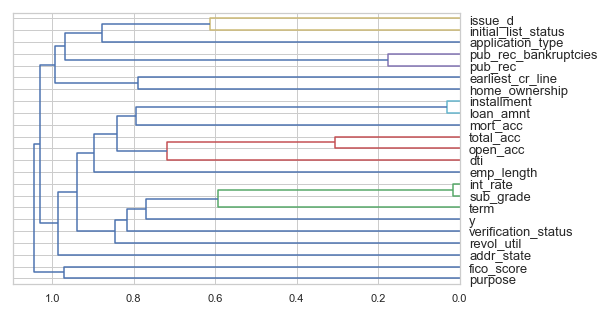

(1344777, 21)

In [104]:
link_plot(data)
df3.shape

In [131]:
imp_all3 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[]] # try to take the average importance
per_all3 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[]]
auc3 =[]
for i in np.arange(30):
    df = df3.sample(50000)
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=6, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    auc3.append(print_score(forest)[2])
    
    feature_importances = forest.feature_importances_
    for e in np.arange(len(feature_importances)):
        imp_all3[e].append(feature_importances[e])
        
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2) 
    
    imp_df = pd.DataFrame(df.columns[:-1])
    imp_df["per"]= np.nan
    for i in np.arange(len(df.columns[:-1])):
        for j in np.arange(len(perm_imp_rfpimp.index)):
            if df.columns[i] == perm_imp_rfpimp.index[j] :
                imp_df["per"][i] = perm_imp_rfpimp.values[j]
    list_per = imp_df["per"].values.tolist()
    
    for j in np.arange(len(list_per)):
        per_all3[j].append(list_per[j])
        
newper3 = [np.mean(i) for i in per_all3]
newimp3 = [np.mean(i) for i in imp_all3]


0
[0.805125, 0.7975, 0.714284125412225, 0.801775]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
[0.805675, 0.8024, 0.7155579954951765, 0.8014]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
[0.81065, 0.7989, 0.7199765292023935, 0.806125]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
[0.808125, 0.8089, 0.7153286148927392, 0.802875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4
[0.802175, 0.8074, 0.7218389455094809, 0.79645]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5
[0.8052, 0.8057, 0.7161470012067421, 0.8016]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6
[0.808125, 0.8078, 0.7065838425241753, 0.80435]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
[0.80455, 0.8054, 0.7201386731011715, 0.7999]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8
[0.8077, 0.8114, 0.7141347665982825, 0.80335]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9
[0.80465, 0.804, 0.7113105687391494, 0.8001]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10
[0.8076, 0.8032, 0.6990146592678406, 0.80365]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11
[0.8022, 0.8043, 0.72041233892072, 0.797375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


12
[0.80475, 0.8015, 0.7080121282387514, 0.80125]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13
[0.8054, 0.8054, 0.7157143660893983, 0.800675]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


14
[0.80755, 0.8024, 0.7154883579514308, 0.80375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


15
[0.805275, 0.804, 0.720045982034705, 0.8005]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


16
[0.8099, 0.7968, 0.7192963872134884, 0.8065]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


17
[0.80835, 0.8063, 0.7081554981228614, 0.804325]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18
[0.807775, 0.8059, 0.7135493671473216, 0.803625]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


19
[0.80455, 0.7981, 0.7184751300259455, 0.799575]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


20
[0.807175, 0.8051, 0.7178811689666288, 0.803575]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


21
[0.808025, 0.809, 0.7097570909445179, 0.804525]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


22
[0.808175, 0.8022, 0.7204634703892678, 0.80295]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


23
[0.80505, 0.8012, 0.7192816440264717, 0.7999]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24
[0.806375, 0.8022, 0.7170944221407041, 0.801375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


25
[0.8059, 0.8128, 0.7223634529594563, 0.8016]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


26
[0.8061, 0.8105, 0.7106074941960725, 0.802175]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


27
[0.80565, 0.8041, 0.7101558979596982, 0.801225]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


28
[0.8096, 0.8012, 0.7043928223629664, 0.8051]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29
[0.804075, 0.8053, 0.715776761460235, 0.80075]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1bd337b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2b9c1b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a360878d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1a3aa6c6a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a3596bef0>,
 'means': []}

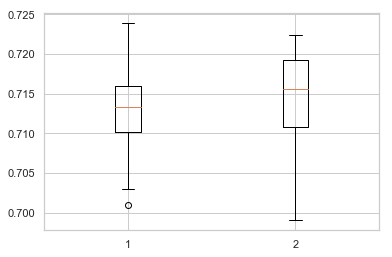

In [132]:
 plt.boxplot([auc,auc3])
# 0.7142657 for 19
#0.7116115016425757 #15
#0.7130350695537234 #22

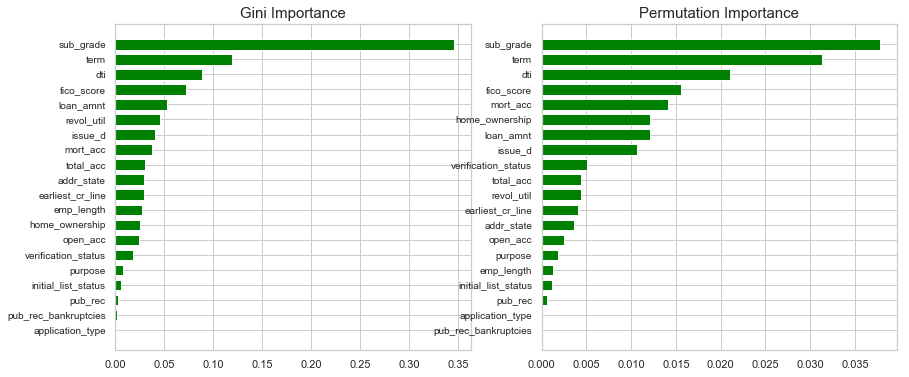

In [133]:
feature_columns = df3.columns
sorted_idx = np.argsort(-np.array(newimp3))
y_pos  = np.arange(sorted_idx.shape[0])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.barh(y_pos, 
            np.array(newimp3)[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
ax1.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax1.set_title('Gini Importance',fontsize = 15)

sorted_idxp = np.argsort(-np.array(newper3))
y_posp  = np.arange(sorted_idxp.shape[0])
ax2.barh(y_pos, 
            np.array(newper3)[sorted_idxp], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax2.set_yticks(y_posp)
ax2.set_yticklabels(feature_columns[sorted_idxp],fontsize = 10)
ax2.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax2.set_title('Permutation Importance',fontsize = 15)
fig.savefig("21imp.png", bbox_inches='tight')


In [135]:

df4= df3.drop(["fico_score"],axis =1)

In [159]:
df3.columns

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type', 'loan_amnt',
       'issue_d', 'dti', 'earliest_cr_line', 'emp_length', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'fico_score', 'y'],
      dtype='object')

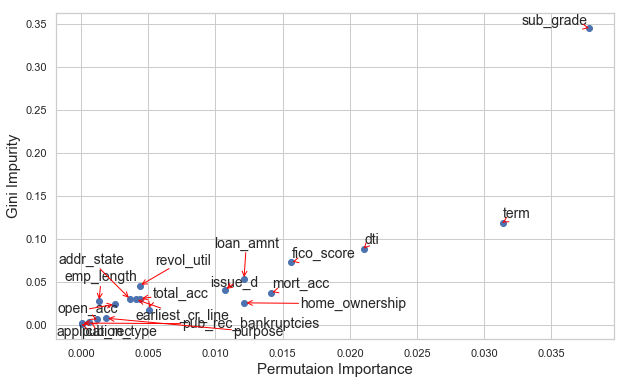

In [160]:
df3.columns
fig, ax = plt.subplots(figsize =(10,6))
x = newper3; y = newimp3
ax.set_xlabel('Permutaion Importance',fontsize = 15)
ax.set_ylabel('Gini Impurity',fontsize = 15)

plt.plot(x, y, 'bo');
label = ['term', 'sub_grade', 'home_ownership', ' ', 'purpose',
       'addr_state', ' ', 'application_type', 'loan_amnt',
       'issue_d', 'dti', 'earliest_cr_line', 'emp_length', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'fico_score']
texts = []
for x, y, text in zip(x, y, label):
    texts.append(ax.text(x, y, text,size=14))
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
fig.savefig("21scatter.png", bbox_inches='tight')


In [136]:
imp_all4 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[]] # try to take the average importance
per_all4 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[]]
auc4 =[]
for i in np.arange(30):
    df = df4.sample(50000)
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=6, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    auc4.append(print_score(forest)[2])
    
    feature_importances = forest.feature_importances_
    for e in np.arange(len(feature_importances)):
        imp_all4[e].append(feature_importances[e])
        
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2) 
    
    imp_df = pd.DataFrame(df.columns[:-1])
    imp_df["per"]= np.nan
    for i in np.arange(len(df.columns[:-1])):
        for j in np.arange(len(perm_imp_rfpimp.index)):
            if df.columns[i] == perm_imp_rfpimp.index[j] :
                imp_df["per"][i] = perm_imp_rfpimp.values[j]
    list_per = imp_df["per"].values.tolist()
    
    for j in np.arange(len(list_per)):
        per_all4[j].append(list_per[j])
        
newper4 = [np.mean(i) for i in per_all4]
newimp4 = [np.mean(i) for i in imp_all4]


0
[0.806925, 0.8086, 0.7056218611379441, 0.802225]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
[0.8066, 0.8049, 0.7054230148622957, 0.8019]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
[0.80615, 0.801, 0.7108665060180948, 0.802625]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
[0.806075, 0.797, 0.7222887538461876, 0.8009]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4
[0.803675, 0.8058, 0.7089352045712745, 0.798775]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5
[0.80805, 0.8014, 0.702564968282112, 0.803425]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6
[0.804075, 0.8002, 0.7096718256740873, 0.800875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
[0.811375, 0.8021, 0.7043047067884843, 0.8075]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8
[0.806, 0.7995, 0.7055758827762475, 0.801475]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9
[0.810075, 0.7986, 0.7143128082946425, 0.806025]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10
[0.804275, 0.8027, 0.7109760034063923, 0.800875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11
[0.8082, 0.802, 0.7105550939592429, 0.80415]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


12
[0.8105, 0.804, 0.7111137801771277, 0.8062]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13
[0.806825, 0.8061, 0.7122744766818554, 0.800825]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


14
[0.80615, 0.8076, 0.705306418578372, 0.800925]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


15
[0.802775, 0.7976, 0.7113693665801286, 0.798575]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


16
[0.807, 0.8032, 0.7184774482930476, 0.80295]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


17
[0.80585, 0.8086, 0.7124696147233271, 0.8005]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18
[0.808075, 0.8089, 0.7069073717090035, 0.802325]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


19
[0.800825, 0.8041, 0.715963006662174, 0.79765]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


20
[0.808225, 0.8038, 0.7121626361136366, 0.80335]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


21
[0.809425, 0.8013, 0.7143378523833028, 0.805875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


22
[0.80985, 0.7989, 0.7162279731258228, 0.80635]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


23
[0.8053, 0.8017, 0.716368644501861, 0.801775]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24
[0.806425, 0.8013, 0.7122907610573637, 0.8009]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


25
[0.80935, 0.8003, 0.7152836482901564, 0.80375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


26
[0.80865, 0.8022, 0.7053222516388437, 0.804625]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


27
[0.808, 0.804, 0.7116219217974173, 0.803725]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


28
[0.80815, 0.8018, 0.7112561556645035, 0.804525]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29
[0.804925, 0.8065, 0.7234835911499004, 0.801025]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [161]:
df4.columns


Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type', 'loan_amnt',
       'issue_d', 'dti', 'earliest_cr_line', 'emp_length', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'y'],
      dtype='object')

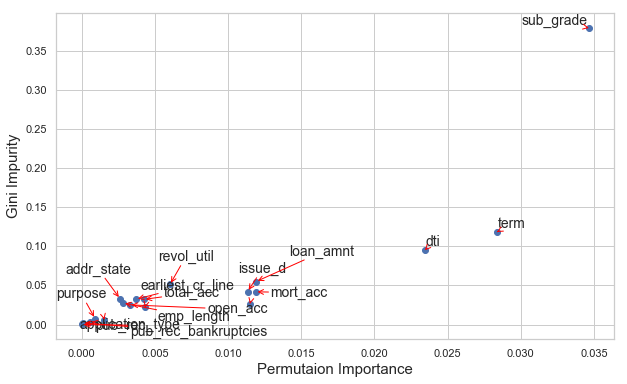

In [162]:
fig, ax = plt.subplots(figsize =(10,6))
x = newper4; y = newimp4
ax.set_xlabel('Permutaion Importance',fontsize = 15)
ax.set_ylabel('Gini Impurity',fontsize = 15)

plt.plot(x, y, 'bo');
label = ['term', 'sub_grade', ' ', ' ', 'purpose',
       'addr_state', ' ', 'application_type', 'loan_amnt',
       'issue_d', 'dti', 'earliest_cr_line', 'emp_length', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies']
texts = []
for x, y, text in zip(x, y, label):
    texts.append(ax.text(x, y, text,size=14))
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
fig.savefig("20scatter.png", bbox_inches='tight')


In [86]:
imp_all2 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[],[],[]] # try to take the average importance
per_all2 =[[],[],[],[],[],[],[],[],[],[],[],[],[],[]]#,[],[],[],[],[],[],[],[]]
auc2 =[]
for i in np.arange(10):
    df = df2.sample(50000)
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=6, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    auc2.append(print_score(forest)[2])
    
    feature_importances = forest.feature_importances_
    for e in np.arange(len(feature_importances)):
        imp_all2[e].append(feature_importances[e])
        
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2) 
    
    imp_df = pd.DataFrame(df.columns[:-1])
    imp_df["per"]= np.nan
    for i in np.arange(len(df.columns[:-1])):
        for j in np.arange(len(perm_imp_rfpimp.index)):
            if df.columns[i] == perm_imp_rfpimp.index[j] :
                imp_df["per"][i] = perm_imp_rfpimp.values[j]
    list_per = imp_df["per"].values.tolist()
    
    for j in np.arange(len(list_per)):
        per_all2[j].append(list_per[j])
        
newper2 = [np.mean(i) for i in per_all2]
newimp2 = [np.mean(i) for i in imp_all2]


0
[0.811675, 0.8045, 0.7240537213044087, 0.805875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
[0.8108, 0.7949, 0.7004297240497885, 0.803725]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
[0.808075, 0.8011, 0.7082321265672268, 0.801875]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
[0.810575, 0.8021, 0.7025881452820166, 0.8058]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4
[0.810025, 0.8054, 0.7138514436673113, 0.804275]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5
[0.808475, 0.7993, 0.7109218499528014, 0.8036]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6
[0.81025, 0.8067, 0.7092418582940074, 0.804125]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
[0.8078, 0.8088, 0.706441132624696, 0.802375]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8
[0.807525, 0.8032, 0.7074506085656813, 0.802825]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9
[0.80575, 0.7995, 0.7151237706883997, 0.80035]


/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


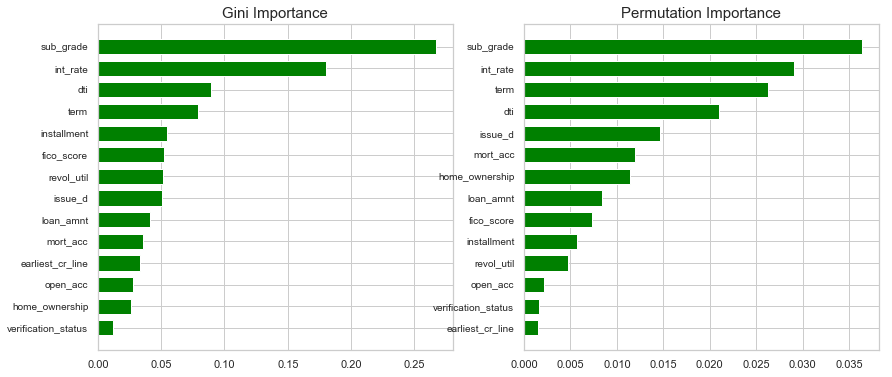

In [89]:
feature_columns = df2.columns
sorted_idx = np.argsort(-np.array(newimp2))
y_pos  = np.arange(sorted_idx.shape[0])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.barh(y_pos, 
            np.array(newimp2)[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
ax1.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax1.set_title('Gini Importance',fontsize = 15)

sorted_idxp = np.argsort(-np.array(newper2))
y_posp  = np.arange(sorted_idxp.shape[0])
ax2.barh(y_pos, 
            np.array(newper2)[sorted_idxp], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
ax2.set_yticks(y_posp)
ax2.set_yticklabels(feature_columns[sorted_idxp],fontsize = 10)
ax2.invert_yaxis()
    #ax1.set_xlabel('Relative Importance',fontsize = 15)
ax2.set_title('Permutation Importance',fontsize = 15)
fig.savefig("15imp.png", bbox_inches='tight')


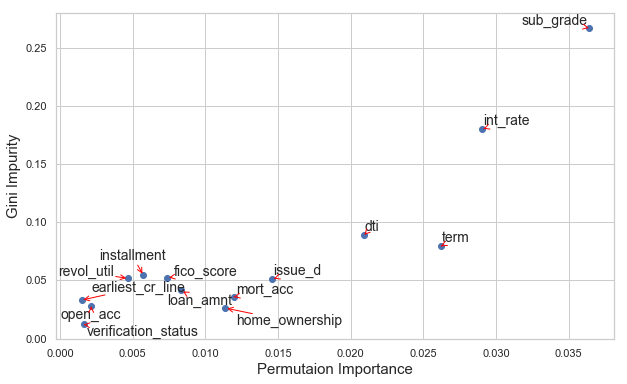

In [91]:
#df3.columns
fig, ax = plt.subplots(figsize =(10,6))
x = newper2; y = newimp2
ax.set_xlabel('Permutaion Importance',fontsize = 15)
ax.set_ylabel('Gini Impurity',fontsize = 15)

plt.plot(x, y, 'bo');
label = df2.columns
texts = []
for x, y, text in zip(x, y, label):
    texts.append(ax.text(x, y, text,size=14))
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
fig.savefig("15scatter.png", bbox_inches='tight')


In [646]:
olddata = data[data["issue_d"]<=2013]
olddata.shape

(227957, 23)

In [60]:
link_plot(df)

NameError: name 'scipy' is not defined

In [713]:
data = loans[loans["dti"] <= 100]

In [714]:
df = data.sample(50000)
df.shape
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)


[0.809175, 0.8047, 0.7108617217112115, 0.8022]


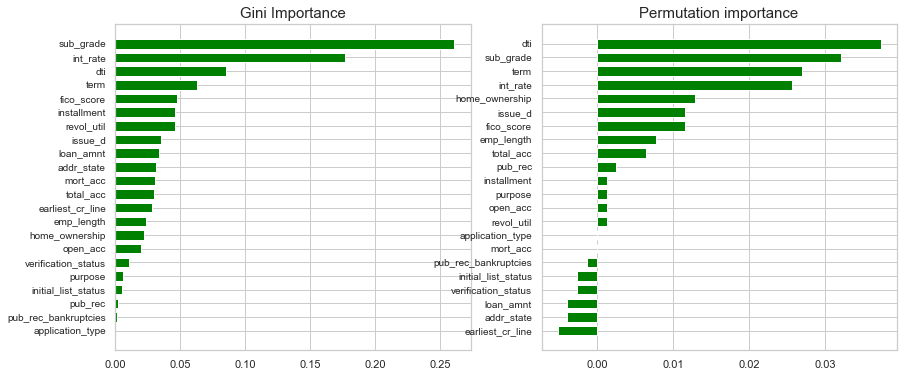

[0.808675, 0.8047, 0.7094894384521937, 0.80215]


<Figure size 432x288 with 0 Axes>

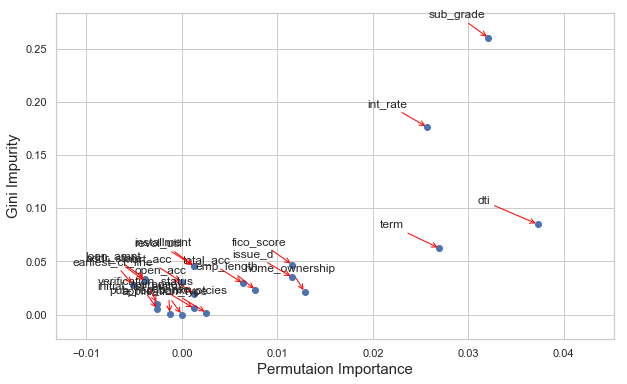

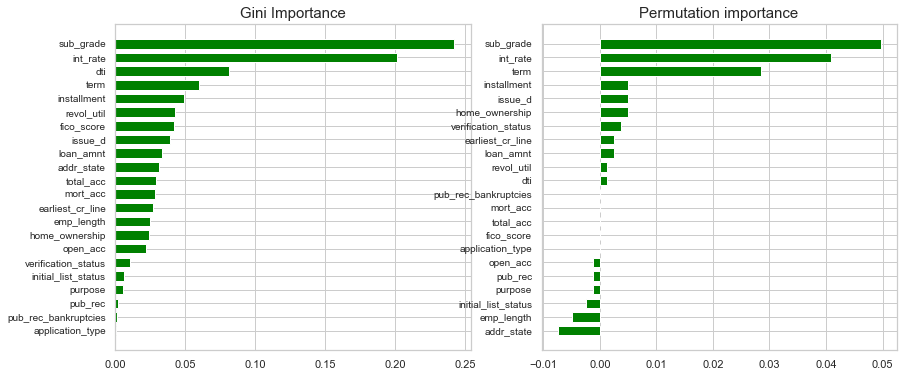

[0.8089, 0.8045, 0.7106312667602163, 0.8016]


<Figure size 432x288 with 0 Axes>

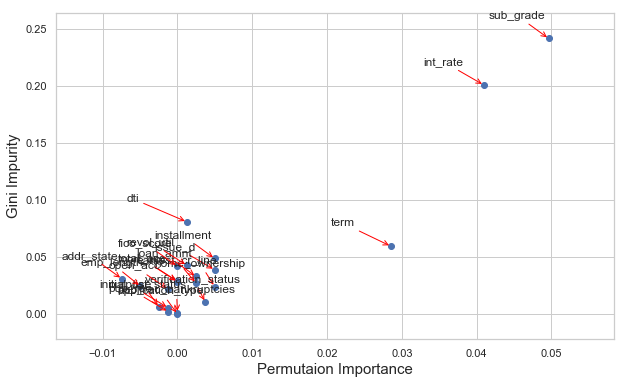

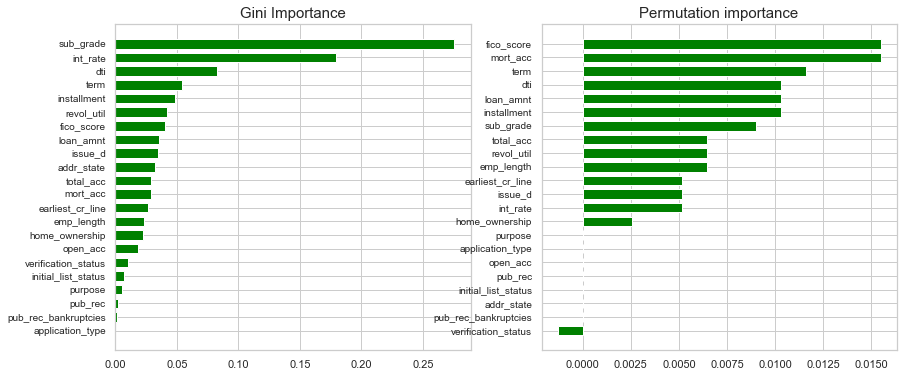

[0.80925, 0.8037, 0.7106882473799678, 0.802175]


<Figure size 432x288 with 0 Axes>

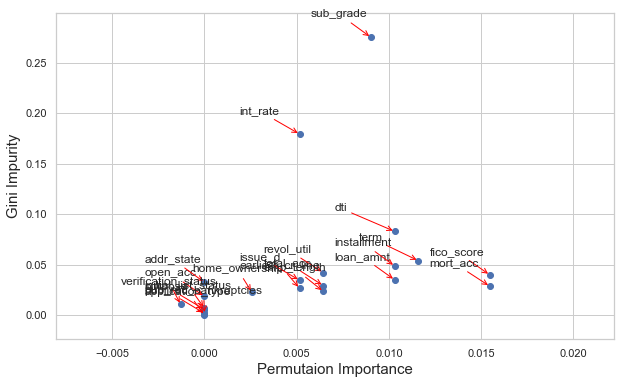

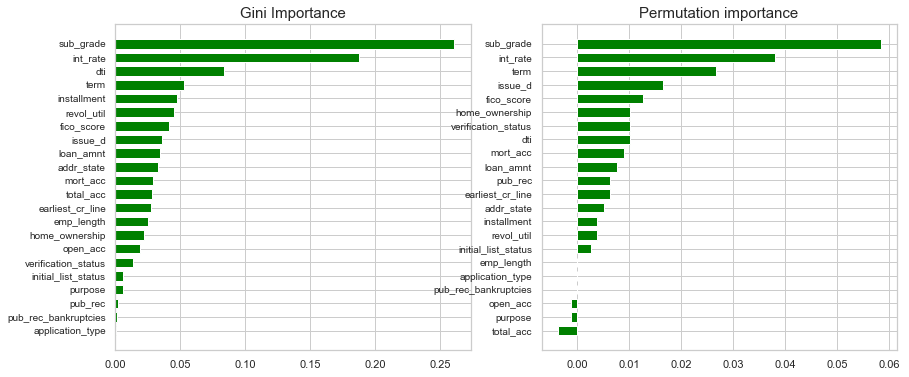

[0.8089, 0.8047, 0.7092555013522135, 0.802475]


<Figure size 432x288 with 0 Axes>

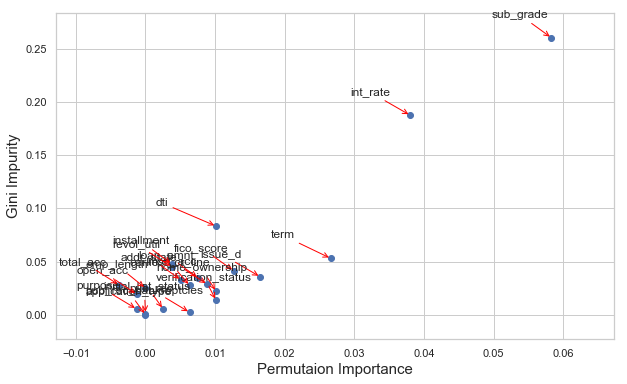

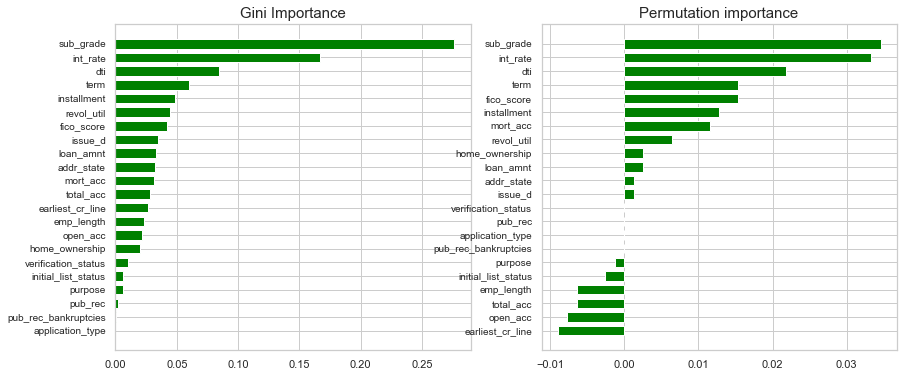

[0.8087, 0.8046, 0.7106157553692838, 0.801875]


<Figure size 432x288 with 0 Axes>

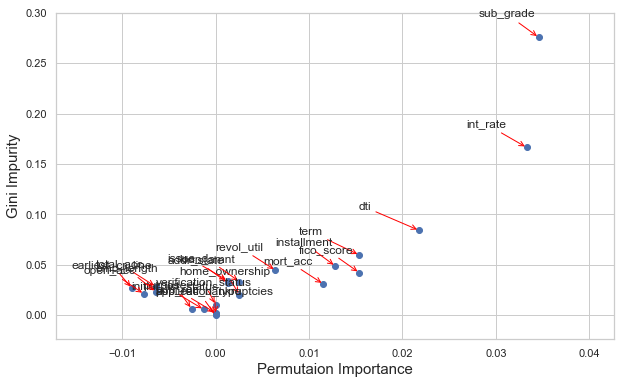

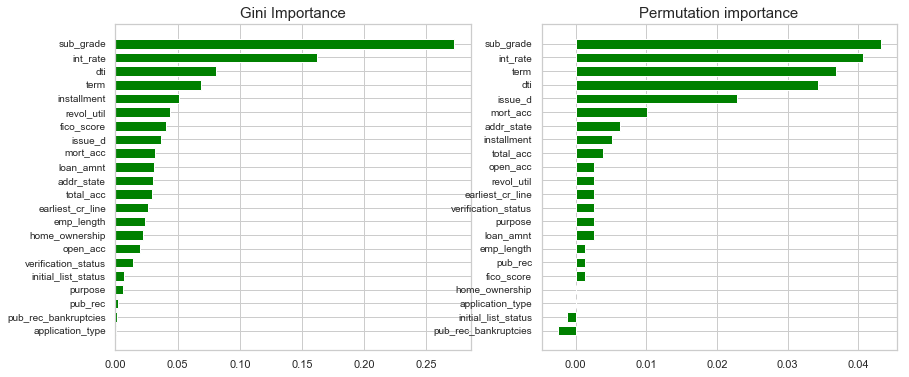

[0.80905, 0.8046, 0.7098031484198262, 0.8023]


<Figure size 432x288 with 0 Axes>

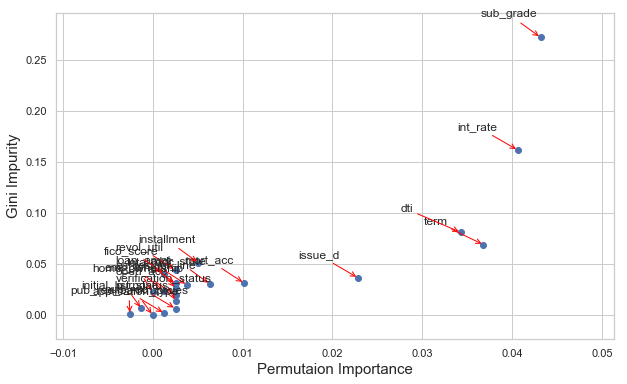

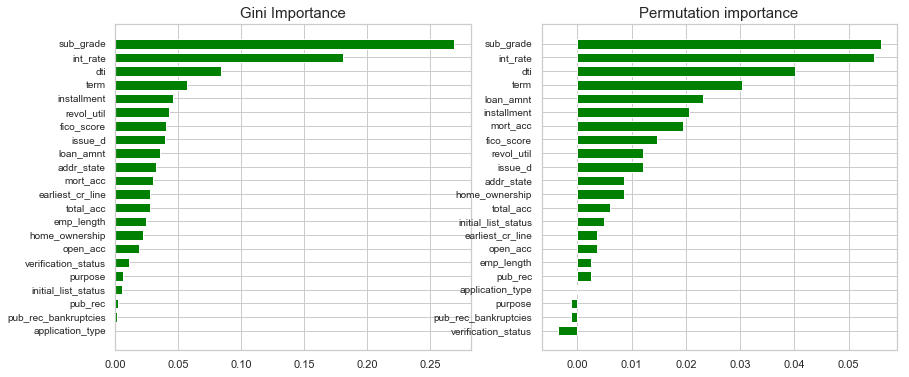

[0.808875, 0.8043, 0.7102276540369756, 0.801475]


<Figure size 432x288 with 0 Axes>

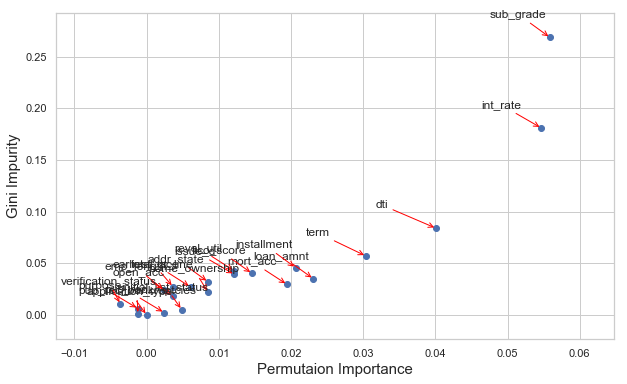

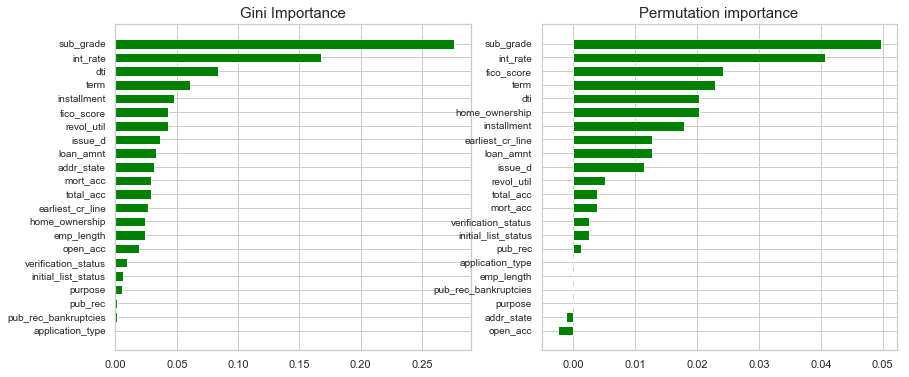

[0.808725, 0.8045, 0.7107850511217457, 0.8028]


<Figure size 432x288 with 0 Axes>

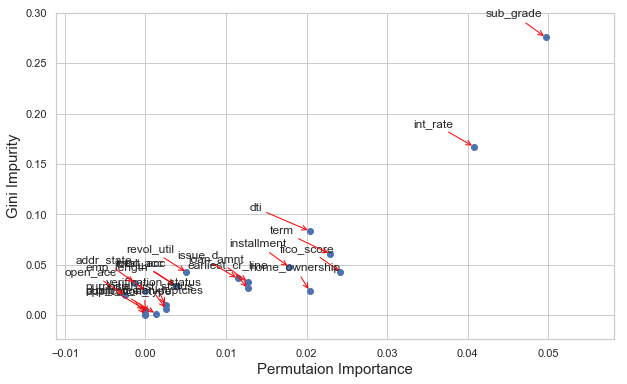

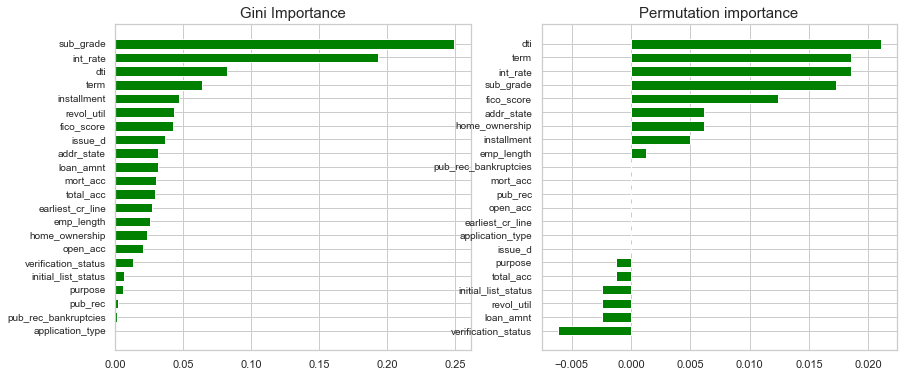

[0.808775, 0.8054, 0.7098194828641549, 0.80225]


<Figure size 432x288 with 0 Axes>

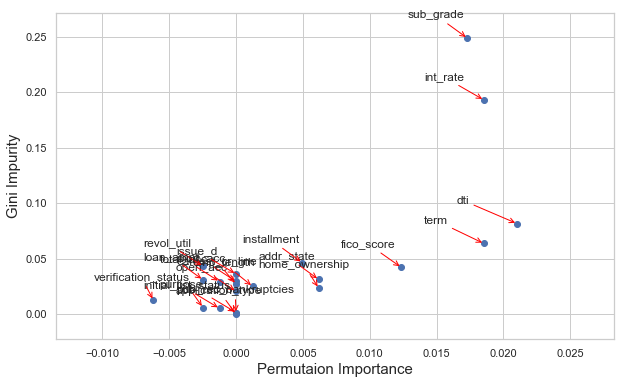

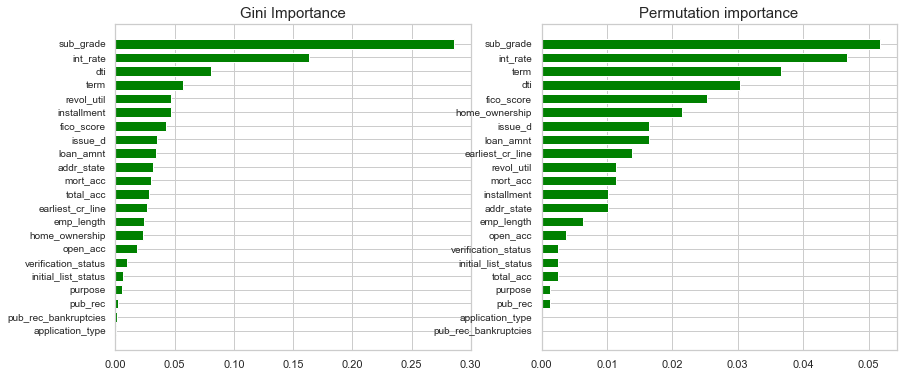

<Figure size 432x288 with 0 Axes>

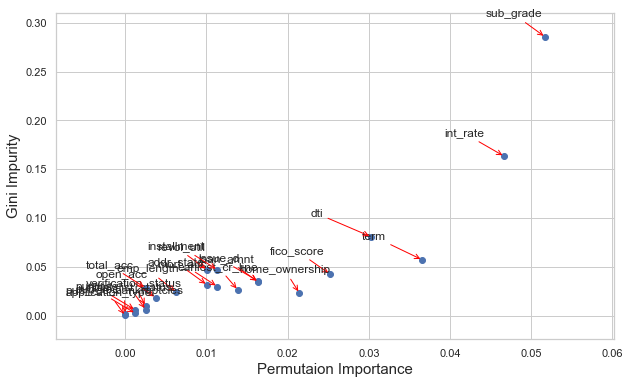

In [716]:
auc = []
for i in np.arange(10):
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, max_features=0.5, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    auc.append(print_score(forest)[2])
    feature_importances, perm_imp_rfpimp =  Plot_predictor_importance(forest, df);
    two_imp(df,forest,perm_imp_rfpimp) 
    #link_plot(df)

In [719]:
df = df.drop(["application_type","pub_rec_bankruptcies","addr_state","total_acc","pub_rec",
              "purpose","emp_length","initial_list_status"],axis =1)

In [717]:
np.mean(auc)

0.710217726746779

[0.809925, 0.7972, 0.7130867240698366, 0.8045]


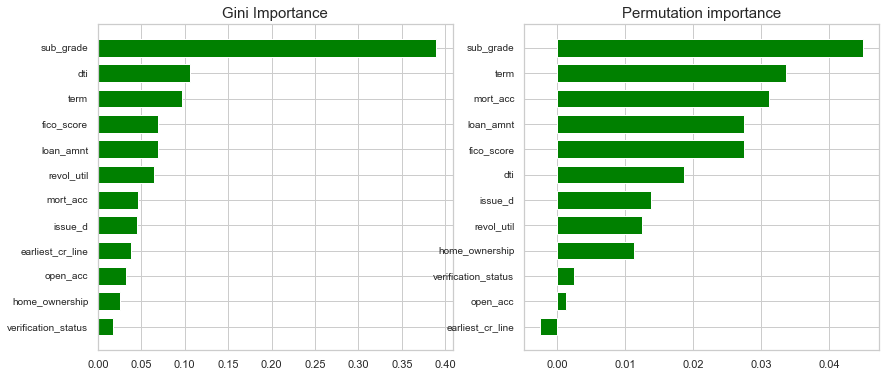

[0.8073, 0.8082, 0.7021693914799032, 0.8023]


<Figure size 432x288 with 0 Axes>

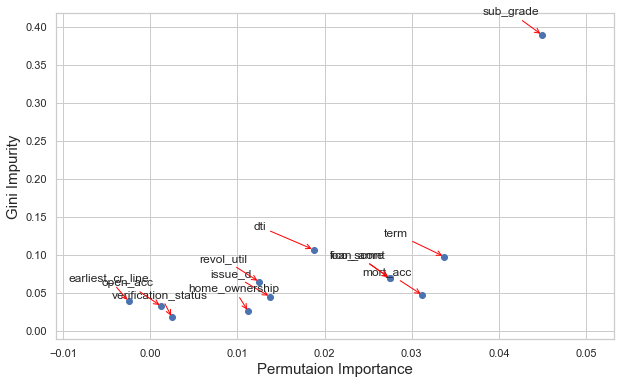

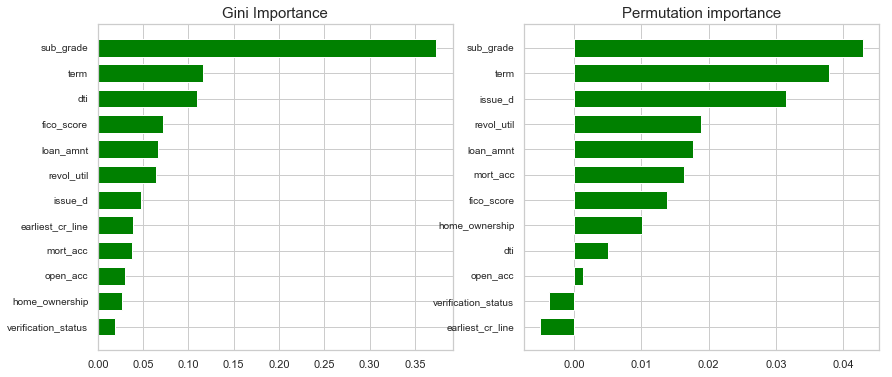

[0.8074, 0.8054, 0.7089185692409884, 0.802425]


<Figure size 432x288 with 0 Axes>

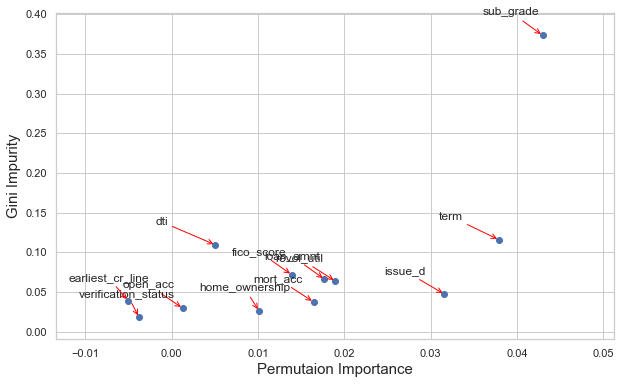

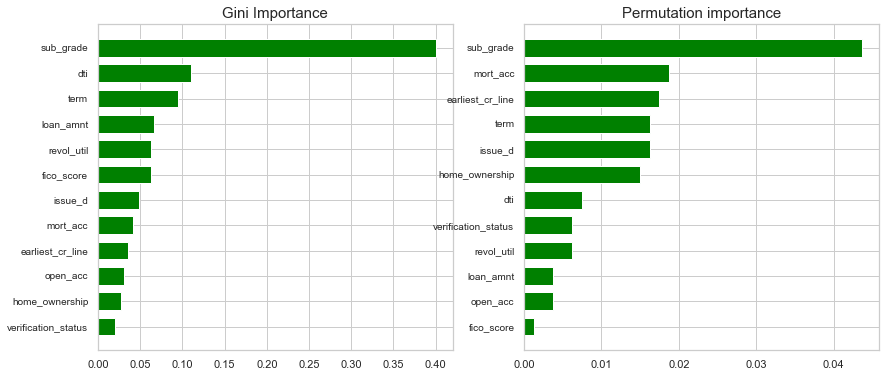

[0.80855, 0.8018, 0.7089495625, 0.80285]


<Figure size 432x288 with 0 Axes>

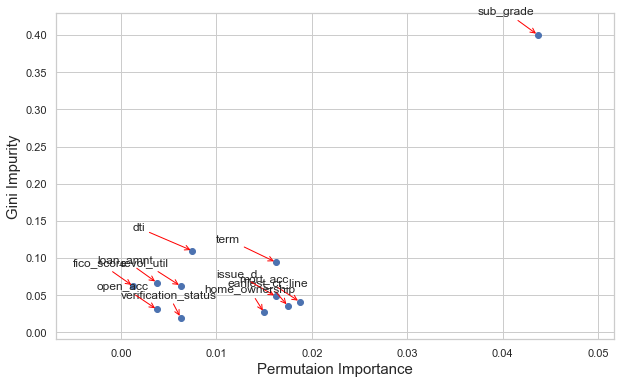

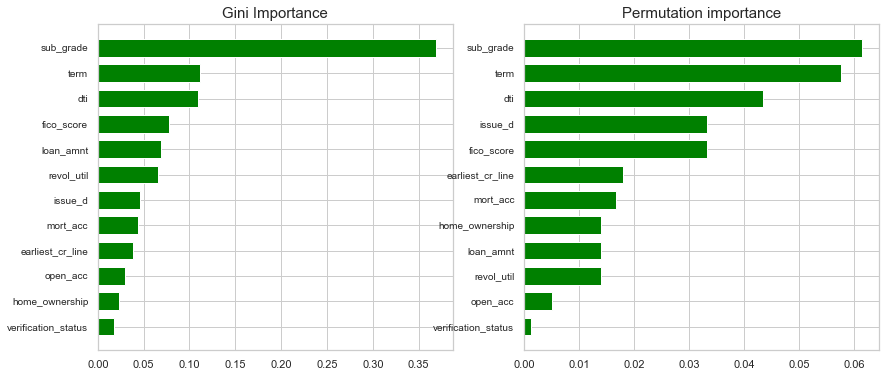

[0.808575, 0.8074, 0.7040887345998142, 0.802725]


<Figure size 432x288 with 0 Axes>

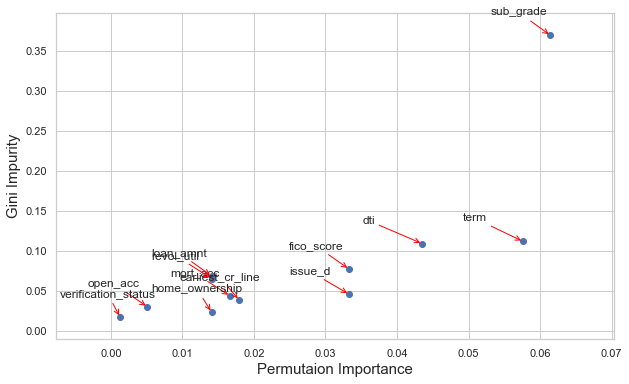

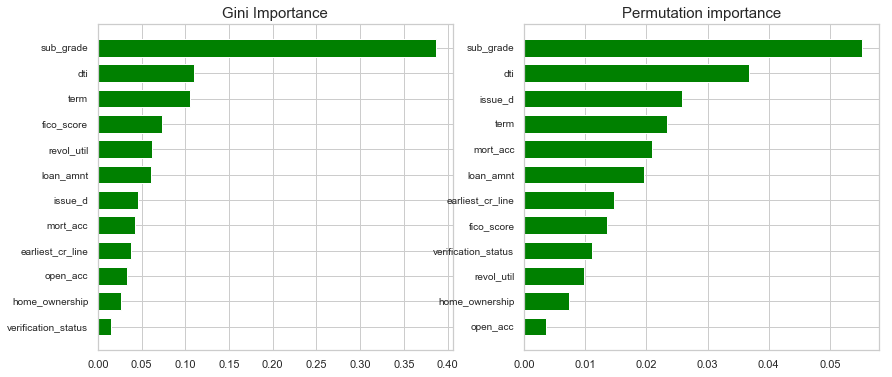

[0.809575, 0.7988, 0.7046227460833578, 0.80415]


<Figure size 432x288 with 0 Axes>

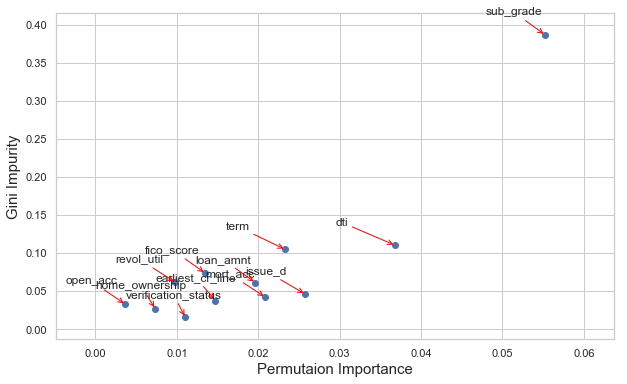

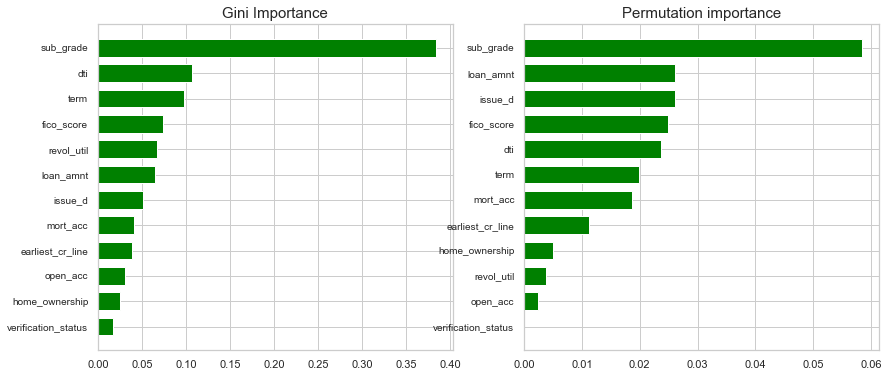

[0.80855, 0.8035, 0.7064225614824727, 0.8033]


<Figure size 432x288 with 0 Axes>

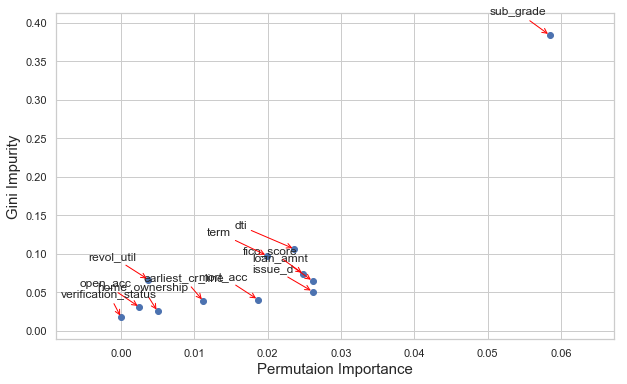

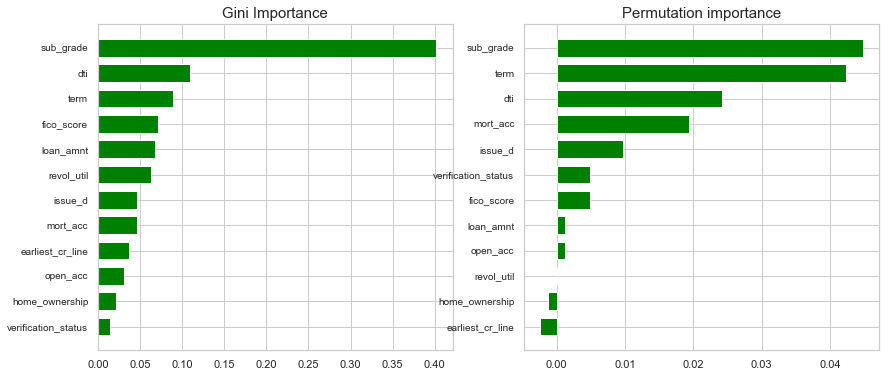

[0.807875, 0.8036, 0.7112771895615319, 0.8025]


<Figure size 432x288 with 0 Axes>

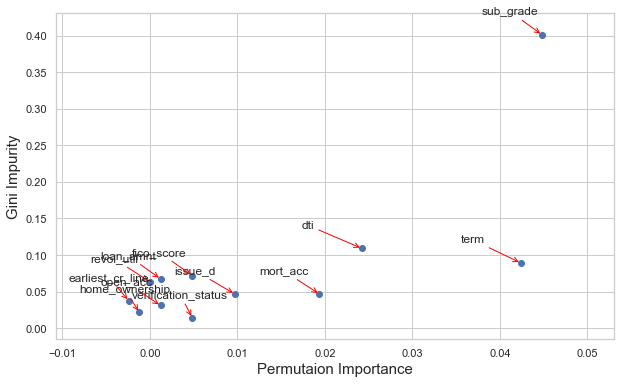

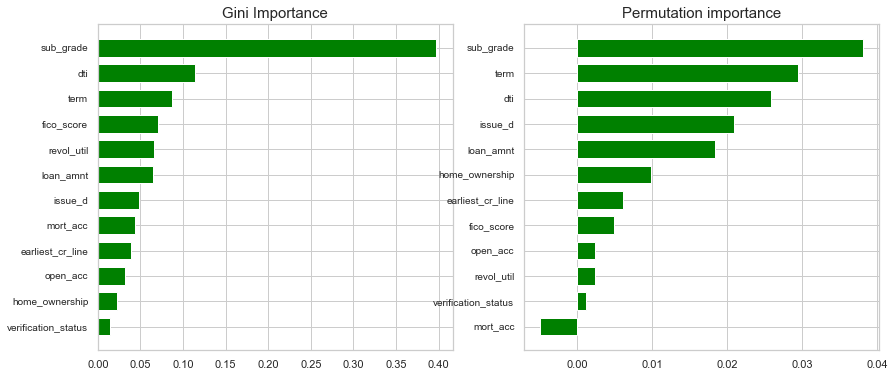

[0.805775, 0.8122, 0.7215866039723517, 0.8001]


<Figure size 432x288 with 0 Axes>

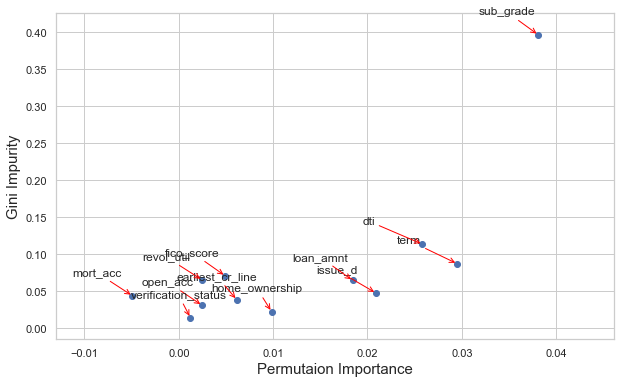

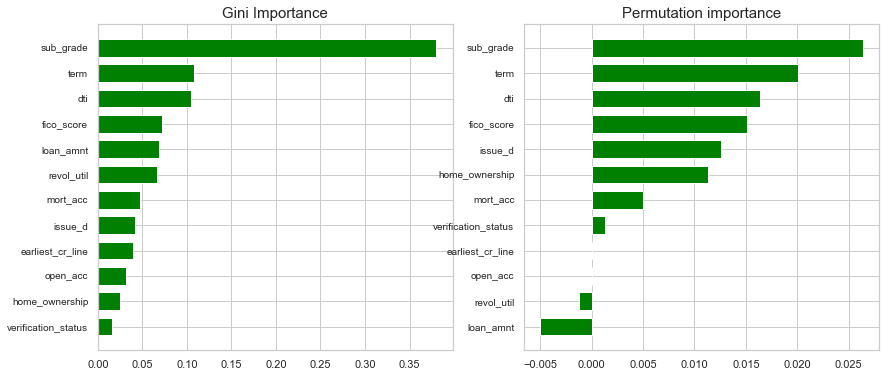

[0.808775, 0.8015, 0.7003373967604173, 0.8037]


<Figure size 432x288 with 0 Axes>

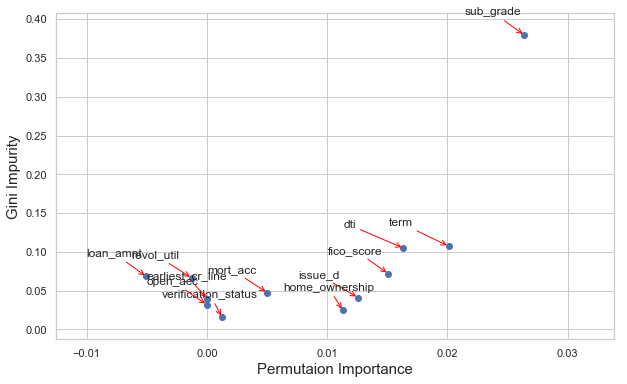

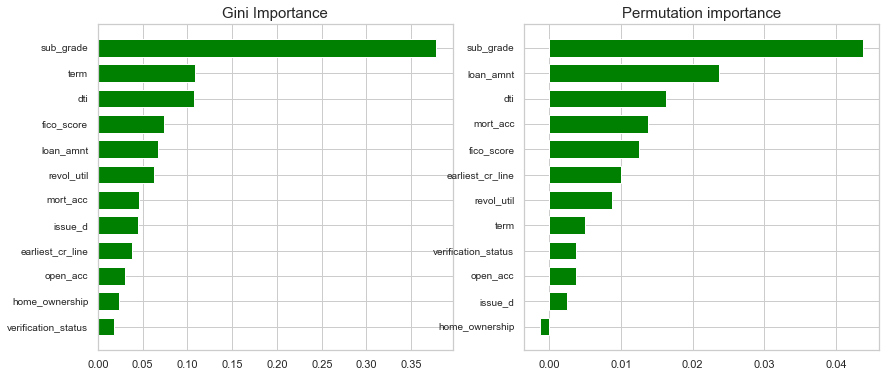

<Figure size 432x288 with 0 Axes>

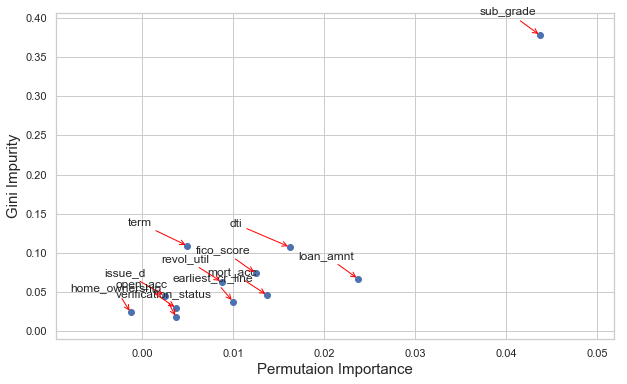

In [722]:
#df = df.drop(['int_rate',"installment"],axis =1)
auc_s = []
for i in np.arange(10):
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=70, min_samples_leaf=60, 
                                max_features=6, n_jobs=-1, oob_score=True, criterion= "gini")
    forest.fit(X_train, y_train)
    auc_s.append(print_score(forest)[2])
    feature_importances, perm_imp_rfpimp =  Plot_predictor_importance(forest, df)
    two_imp(df,forest,perm_imp_rfpimp) 

In [723]:
np.mean(auc_s)

0.7081459479750674

In [696]:
#choose which one to drop
df = data.sample(50000)
for i in ('installment', 'loan_amnt', 'int_rate', 'sub_grade',"pub_rec_bankruptcies","pub_rec"):
    oob, forest,perm_imp_rfpimp = get_oob(df.drop(i, axis=1))
    print(i,oob)

installment 0.800625
loan_amnt 0.800175
int_rate 0.80065
sub_grade 0.7992
pub_rec_bankruptcies 0.7995
pub_rec 0.80015


[0.95905, 0.8034, 0.7031955850463046, 0.796525]


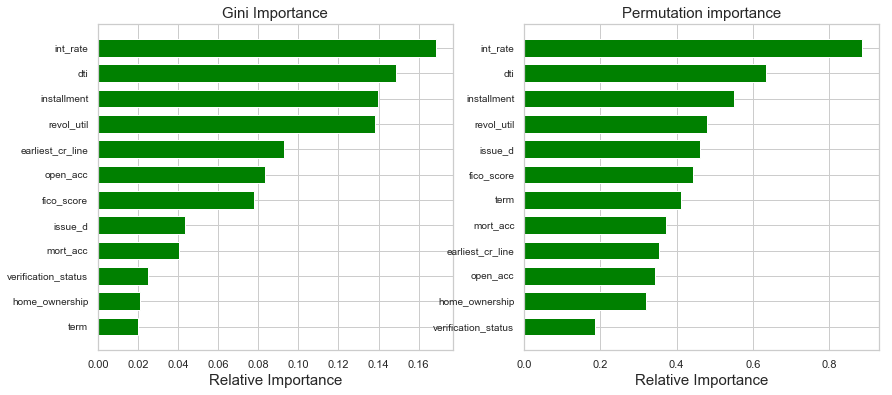

In [442]:
df = data.drop(['sub_grade',"loan_amnt"],axis =1)
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                                max_features=0.5, n_jobs=-1, oob_score=True, criterion= "gini")
forest.fit(X_train, y_train)
print_score(forest)
feature_importances, perm_imp_rfpimp =  Plot_predictor_importance(forest, df)

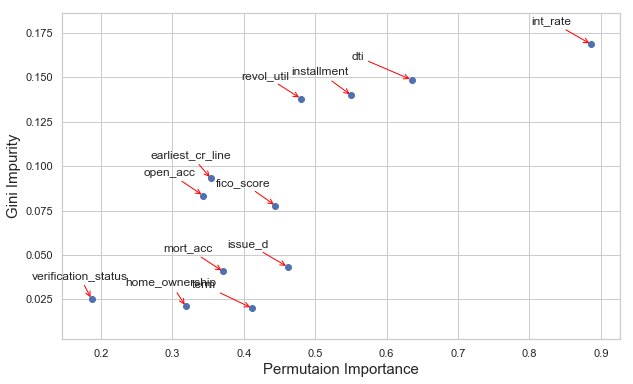

In [443]:
two_imp(df,forest,perm_imp_rfpimp) # all data

In [687]:
data = loans[loans["dti"] <= 100]

[0.938075, 0.8072, 0.6913169734942244, 0.79605]


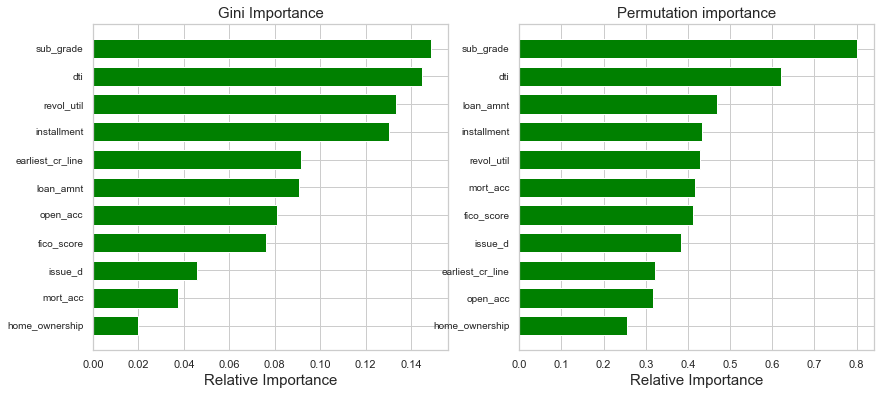

In [446]:
data = data.drop(['int_rate',"verification_status","term"],axis =1)
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], test_size=0.2)
forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)

print_score(forest)
feature_importances, perm_imp_rfpimp =  Plot_predictor_importance(forest, data)

In [292]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
plot_partial_dependence(forest, features=[1, 6], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=['sub_grade', 'dti'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

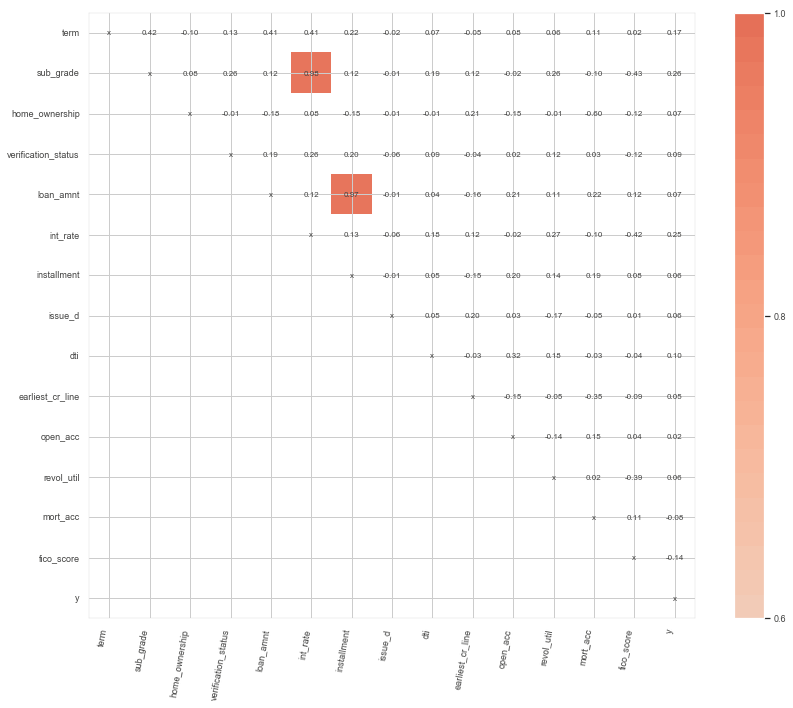

In [468]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(data, figsize=(14,10))
viz.view()

In [145]:
pip install pdpbox

Note: you may need to restart the kernel to use updated packages.


In [147]:
from pdpbox import pdp, get_dataset, info_plots
from plotnine import *

In [146]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


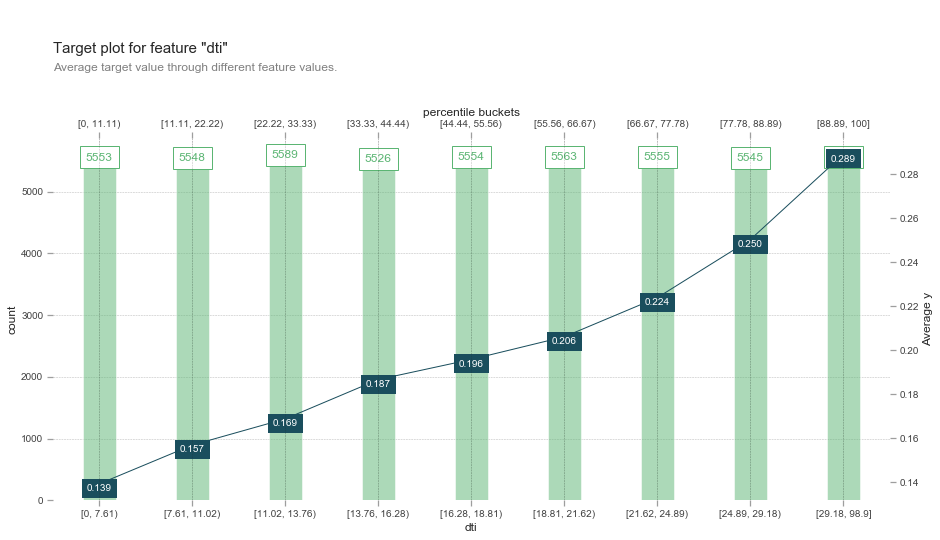

In [395]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='dti', feature_name='dti', target="y", show_percentile=True
)

In [660]:
df.shape

(50000, 23)

In [151]:
mple(X_train[X_train["dti"]>50], 500)

In [152]:
fig, axes, summary_df = info_plots.actual_plot(forest,X = data, feature='dti', 
                                               feature_name='dti', show_percentile=True)

TypeError: predict_proba() argument after ** must be a mapping, not NoneType

In [168]:
data.shape
#get_sa

(1344777, 23)

In [169]:
def plot_pdp(feat,df, clusters=None, feat_name=None):
    df= df.sample(50000)
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2)
    forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    forest.fit(X_train, y_train)
    x = X_train.sample(2000)
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(forest, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, plot_pts_dist = True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)
#plot_pdp('dti');

In [174]:
data.sample(20)[["sub_grade","fico_score"]]

sub_grade  fico_score
2112094          8       707.0
1213545          0       827.0
1117776          3       792.0
2234135          6       682.0
1977901         10       712.0
1627129         18       662.0
1264449         11       732.0
175607           6       682.0
1308631          1       707.0
1700637          7       727.0
1334742         14       687.0
537894          21       707.0
349922           0       697.0
1002693          3       717.0
384603          15       682.0
2231431          6       702.0
1795516          7       672.0
1072210          8       732.0
1590701          9       692.0
997900           0       762.0

In [171]:
data["sub_grade"].corr(data["fico_score"])

-0.42370314746449705

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a32d03f60>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a32cf18d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a305acef0>}})

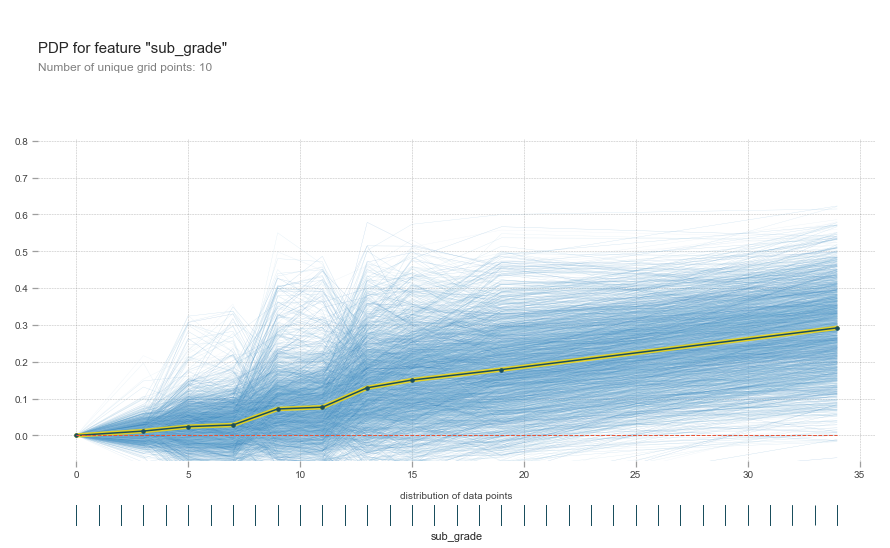

In [176]:
plot_pdp("sub_grade",df3)

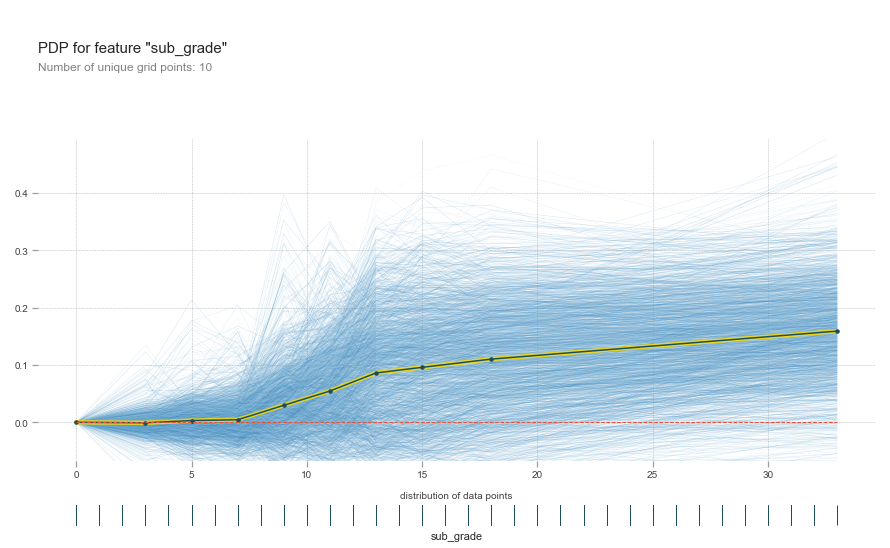

In [185]:
plot_pdp('sub_grade',data);

In [183]:
data.shape

(1344777, 23)

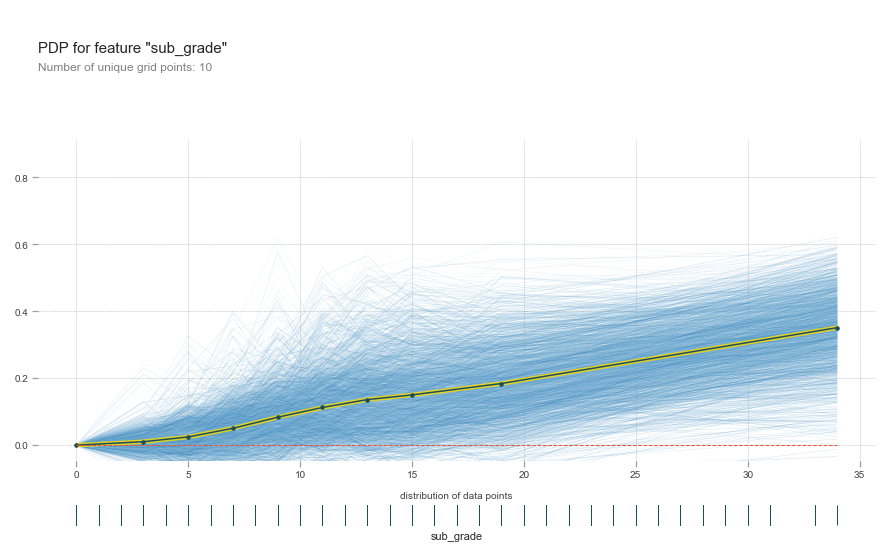

In [188]:
plot_pdp('sub_grade',df3);

In [189]:
import scipy

In [187]:
df = data.copy()

In [232]:
def r2(forest, X_train, y_train):
    return r2_score(y_train, forest.predict(X_train))

In [239]:
#define function to calculate oob score
def get_oob(data):
    m = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], 
                                                        data[data.columns[-1]], test_size=0.2)    
    m.fit(X_train, y_train)
    perm_imp_rfpimp = permutation_importances(m, X_train, y_train, r2)
    return m.oob_score_ , m, perm_imp_rfpimp


In [196]:
#drop a pair
to_drop = ['installment',"sub_grade"]
print(get_oob(df.drop(to_drop, axis=1)))
print(get_oob(df.drop(['installment',"int_rate"], axis=1)))

0.798725
0.7994


In [259]:
feature_importances = forest.feature_importances_
sorted_idx = np.argsort(-feature_importances)
feature_importances[sorted_idx]

array([0.16191383, 0.14952708, 0.13216407, 0.11846551, 0.10219253,
       0.08878147, 0.08169372, 0.04792775, 0.04207478, 0.02722473,
       0.02538345, 0.02265108])

In [273]:
def two_imp(data,forest,perm_imp_rfpimp):
    fig, ax = plt.subplots(1,1,figsize =(8,7))
    feature_importances = forest.feature_importances_
    perm_imp_rfpimp["gini"] = np.nan
    for i in np.arange(len(feature_importances)):
        for e in np.arange(len(feature_importances)):
            if perm_imp_rfpimp.index.values[i] == data.columns[e]:
                 perm_imp_rfpimp["gini"][i] = feature_importances[e]
    x = np.ravel(perm_imp_rfpimp['Importance']).tolist()
    y = np.ravel(perm_imp_rfpimp['gini']).tolist()
    ax.scatter(x,y)
    ax.set_xlabel('Permutaion Importance',fontsize = 15)
    ax.set_ylabel('Gini Impurity',fontsize = 15)
    label = np.ravel(perm_imp_rfpimp.index.values)
    
    for x, y, label in zip(x, y, label):
        ax.annotate(label, xy=(x, y), xytext=(-60, 20), ha='left',
                textcoords='offset points',arrowprops=dict(arrowstyle="->",color="red"))


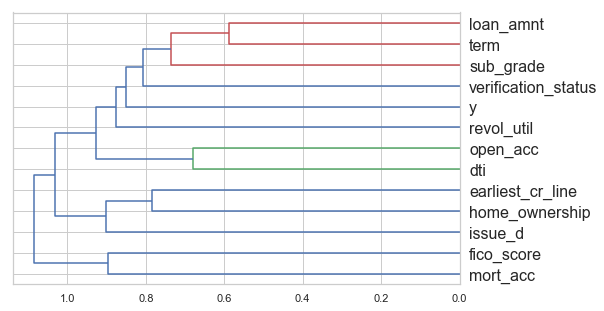

In [201]:
link_plot(df.drop(['installment',"int_rate"],axis =1))

0.79725


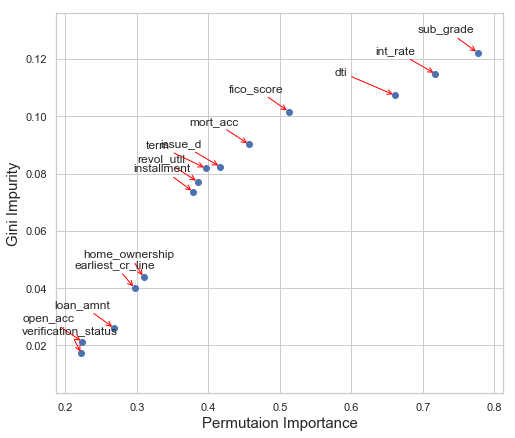

In [246]:
oob,forest,perm_imp_rfpimp = get_oob(df)
print(oob)
two_imp(forest,perm_imp_rfpimp)

0.798525


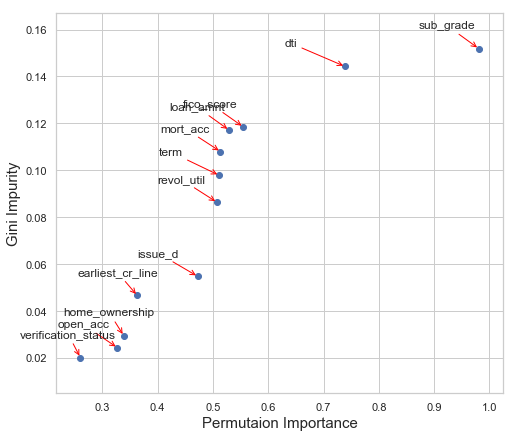

In [245]:
oob,forest,perm_imp_rfpimp = get_oob(df.drop(['installment',"int_rate"],axis =1))
print(oob)
two_imp(forest,perm_imp_rfpimp)

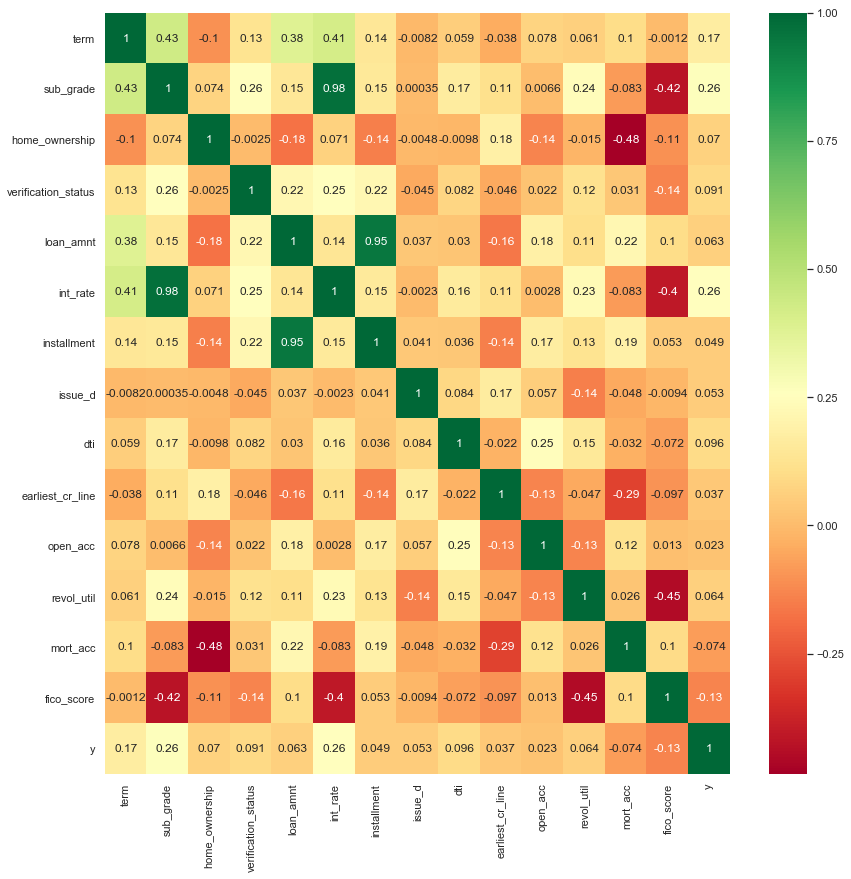

In [180]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,14))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")